- [testing adex](https://nest-simulator.readthedocs.io/en/stable/auto_examples/brette_gerstner_fig_3d.html)

- [neuron model information](https://nest-simulator.readthedocs.io/en/stable/models/neurons.html#classnest_1_1aeif__cond__exp)

`aeif_cond_exp` is the adaptive exponential integrate and fire neuron according to Brette and Gerstner (2005), with post-synaptic conductances in the form of truncated exponentials.

Adaptive Exponential neuronal model, or AdEx for short. It's dynamics are defined by two state variables, the membrane potential and a refractory variable, which indicates the state of the refractory mechanisms (such as sodium inactivation and potassium activation).

In [19]:
# nest
from math import *
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("coolwarm")
# set the path 
path = 'data/'
# seed 
np.random.seed(0)

import SimulationClass_AdEx as simu_adex

# update changes made in python script
reload(simu_adex);

H = simu_adex.HelperFuncs()

patterns = []
# make permutations for 8 bit pattern
for perm in H.make_permutations():
    patterns.append(perm)

# Set AdEx parameter values

In [59]:
# define a function that 'parameterizes' the neuron according to its 'spiking type' (phasic, tonic, ...)

def set_params(name=False):
    
    # neuron parameters (same as LIF)
    N_total = 1200 # total
    NE = 960
    NI = 240
    n_threads = 8
    stim_start = 0.
    stim_end = 150.
    simtime = 1000.
    sub_fr = 0.9
    sup_fr = 1.01
    resolution = 0.1
    J_ex = 6.0
    J_in = -95.0
    t_ref = 2.0
    delay = 1.5
    
    # synaptic params
    E_ex = 0.0
    E_in = -80.0
    tau_syn_ex = 0.326
    tau_syn_in = 0.326
    
    # from (Brette & Gerstner, 2005)
    C_m = 281.0 # capacitance
    g_L = 30.0 # leaky conductance
    E_L = -70.6
    V_th = -50.4
    Delta_T = 2.0 # slope factor
    tau_w = 144.0 # adaptation time constant in ms
    a = 4.0 # subthreshold adaptation in nS
    b = 80.5 # spike-triggered adaptation in pA
    V_peak = 20.# Spike detection threshold
    V_reset = -70.6 # Reset value for V_m after a spike
    
#     # different values from Elias
#     tau_m = C_m/g_L # ??
#     Vcut = V_th + (5*Delta_T) # ??? (same as V_peak?)
#     tau_w = 150.0 # adaptation time constant

#     # stimulation parameters:
#     I0=0.0
#     dv0=0.0 # voltage transient
#     T0=50.0
#     T1=500.0
#     T2=100.0
        
    if name == 'phasic':
        a = 2*(C_m/tau_w) # Subthreshold adaptation (type II)
        b = 0.0 # spike-triggered adaptation
        E_L = -60.0 
#         I_john = (1+a/g_L)*log(1+tau_m/tau_w)-(1+tau_m/tau_w)
#         I0=gL*DeltaT*I_john+(VT-EL)*(gL+a)-0.03
#         I=I0
#         T0=100.0
#         T1=200.0
#         T2=20.0
#         dv0=2.5
        
    elif name=='rebound_spike':
        tau_w = 150.0
#         #T0=
        a = 200.0
        b = 0.1 
        E_L = -60.0
        V_th = -54
        V_reset = E_L
#         I0=0*nA
#         I=-0.5*nA
#         T1=50*ms

    elif name=='rebound_burst':
#        tauw=150*ms
        #T0=
        a = 200.0
        b = 0.1
#         I0=0*nA
#         I=-0.5*nA
        EL = -60.0
#         T1=50*ms
        V_th = -54.0
        V_reset = V_th + 3.0
        
    elif name=='regular':
        
        tau_w = 144.0
        a = 4.0 # subthreshold adaptation in nS
        b = 80.5 # spike-triggered adaptation in pA
       
        V_reset = -70.6
#        I=1*nA
        
    elif name=='on_off':
        
        tau_w = 10.0
        a = 800.0
        b = 10000.0
        V_reset = -70.6
#        I=11*nA
        
    elif name=='oscillator??': # numerical integration problem
        
        tau_w = 14.0
        a = 8000.0
        b = 80.5
        V_reset = -70.6
#       I=1.3*nA

    elif name=='mixed':
        
        tau_w = 144.0
        a = 4.0
        b= 150.0
        V_reset = V_th + 2.0
#        I=1*nA

    elif name=='fast':
        # Type II: a > C/tauw
        tau_w = 144.0
        a = 2*(C_m/tau_w)
        b = 0.0
        V_reset = -70.6
#         I_john=(1+a/gL)*log(1+taum/tauw)-(1+taum/tauw)
#         I=gL*DeltaT*I_john+(VT-EL)*(gL+a)+0.01*nA
#         I0=I-0.1*nA
#         T0=200*ms

    elif name=='bursting_tonic':
        
        tau_w = 20.0
        a = 4.0
        b = 500 
        V_reset = V_th + 5.0
#        I=.8*nA
 
    elif name=='bursting_phasic':
        
        tau_w = 144.0
        a = 4.0
        b = 100
        V_reset = V_th + 4.0
        #I=.6*nA
        
    elif name=='bursting_phasic2': # big burst, then small bursts
        tau_w = 144.0
        a = 4.0
        b = 150.0
        V_reset = V_th + 2.0
        #I=1.5*nA

    # put it all in two dicts
    sim_params = {'N_total':N_total, 'NE':NE, 'NI':NI, 'n_threads':n_threads, 'stim_start':stim_start, 'stim_end':stim_end, 
                  'simtime':simtime, 'sub_fr':sub_fr, 'sup_fr':sup_fr, 'resolution':resolution,'J_ex':J_ex, 
                  'J_in':J_in, 't_ref':t_ref, 'E_ex':E_ex, 'E_in':E_in, 'tau_syn_ex':tau_syn_ex, 'tau_syn_in':tau_syn_in,  
                  'delay':delay
                 }
    
    model_params = {'C_m':C_m, 'g_L':g_L, 'E_L':E_L, 'a':a, 'b':b, 'tau_w':tau_w, 'V_th':V_th,'Delta_T':Delta_T, 
                    'V_reset':V_reset,  'V_peak': V_peak
                   }
    
    return sim_params, model_params

# Functions

In [67]:
def simulate(patterns, sim_params, model_params):
    '''
    Returns
    spike_times_arr: array with the exact timings neurons spiked.
    spike_neurons_arr: array with indices of spiking neurons.
    '''
    
    # initialise classes
    udp = simu_adex.UpDownPatterns(sim_params, model_params)
    
    # make lists
    spike_times_lst = []
    spike_neurons_lst = []
    multimeters = []
    spikedetectors = []

    # time duration
    start = time.time()

    for i, pattern in enumerate(patterns):
        label = H.list2str(pattern)
        multimet, spikedet, spike_times, spike_neurons = udp.simulate(pattern)

        # convert to python lists 
        spike_times.tolist()
        spike_neurons.tolist()

        spike_times_lst.append(spike_times)
        spike_neurons_lst.append(spike_neurons)
        multimeters.append(multimet)
        spikedetectors.append(spikedet)

    end = time.time()
    print(f'Simulation done! time: {round(end-start)} seconds')

    # convert to np arrays
    spike_times_arr = np.array(spike_times_lst)
    spike_neurons_arr = np.array(spike_neurons_lst)
    
    return spike_times_arr, spike_neurons_arr


def get_transient_data(spike_times_arr, spike_neurons_arr, sim_params):
    '''
    Uses the information from the simulation run to get information about the transient.
    '''
    transient_spikes = []
    transient_lifetime = []
    transient_uniquen = []
    transient_time_arr = []
    
    stim_end = sim_params['stim_end']
    
    for trial in range(len(spike_times_arr)):

        # select data from experiment / trial
        times = spike_times_arr[trial]
        neurons = spike_neurons_arr[trial]

        # === number of spikes ===
        num_trans_spikes = sum(1*(times > stim_end))
        transient_spikes.append(num_trans_spikes)
        

        # === transient lifetime ===
        transient_time = times[times > stim_end]
        transient_time_arr.append(transient_time)

        if num_trans_spikes == 0:
            transient_lifetime.append(0)
        else:
            t_dur = round(max(transient_time_arr[trial]) - stim_end,2)
            transient_lifetime.append(t_dur)

        # === transient_size ===
        transients = 1*(times > stim_end)
        transient_indices = np.argwhere(transients)
        # take the neurons from these indices
        active_neurons = np.unique(neurons[transient_indices])
        transient_uniquen.append(active_neurons)

    transient_size = [len(i) for i in transient_uniquen]
    
    return transient_spikes, transient_lifetime, transient_size


def get_metrics(transient_size, transient_lifetime):
    
    df = pd.DataFrame({'transient_size':transient_size, 'transient_lifetime':transient_lifetime})
    
    mins = df.std().tolist()
    means = df.mean().tolist()
    maxs = df.max().tolist()
    
    return mins, means, maxs

def plot(transient_mins, transient_means, transient_maxs, x_axis_name, parameter_range):
    '''
    takes in a list of transient means and max values, name for the x_axis (the parameter value that is being changed) 
    and the range of parameter values used.
    
    Plots the graphs.
    '''
    # [mean transient size, mean transient lifetime]
    trans_size_mins = [i[0] for i in transient_mins]
    trans_lifetime_mins = [i[1] for i in transient_mins]
    
    trans_size_means = [i[0] for i in transient_means]
    trans_lifetime_means = [i[1] for i in transient_means]    

    trans_size_maxs = [item[0] for item in transient_maxs]
    trans_lifetime_maxs = [item[1] for item in transient_maxs]

    # === Plot ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(parameter_range, trans_size_mins, '--go', label='min transient size');
    ax1.plot(parameter_range, trans_size_maxs, '--ro', label ='max transient size');
    ax1.plot(parameter_range, trans_size_means, '--bo', label='mean transient size');
    ax1.set_xlabel(x_axis_name)
    ax1.set_ylabel('transient size (neurons)')
    ax1.legend();
    
    ax2.plot(parameter_range, trans_lifetime_mins, '--go', label ='min transient times');
    ax2.plot(parameter_range, trans_lifetime_maxs, '--ro', label ='max transient times');
    ax2.plot(parameter_range, trans_lifetime_means, '--bo', label='mean transient times');
    ax2.set_xlabel(x_axis_name);
    ax2.set_ylabel('transient lifetime (ms)')
    ax2.legend();

# RUN simulation

In [69]:
# set the parameter value for AdEx Neuron
sim_params, model_params = set_params(name='mixed')

spike_times_arr, spike_neurons_arr = simulate(patterns, sim_params, model_params)

Simulation done! time: 63 seconds


In [71]:
transient_spikes, transient_lifetime, transient_size = get_transient_data(spike_times_arr,spike_neurons_arr, sim_params)

In [72]:
d = {'transient_spikes':transient_spikes, 'transient_lifetime':transient_lifetime, 'transient_size':transient_size}
df = pd.DataFrame(data=d)

In [73]:
df.describe()

,transient_spikes,transient_lifetime,transient_size
count,70.0,70.0,70.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


## Raster plots

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


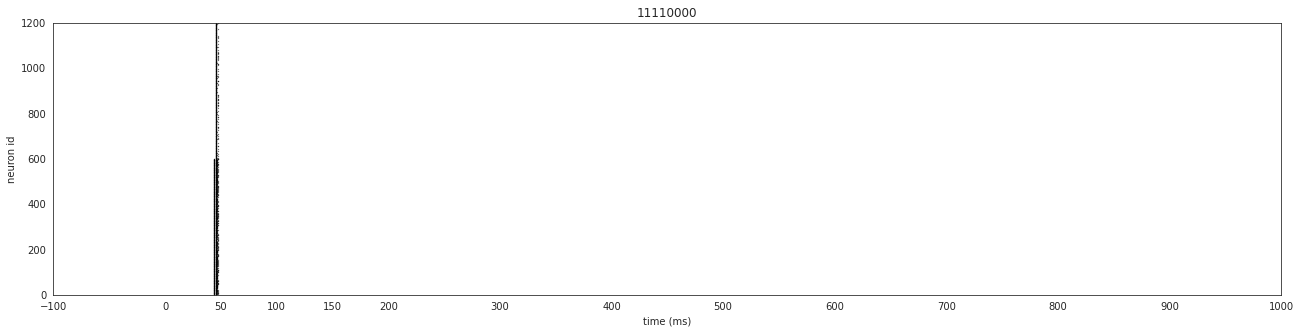

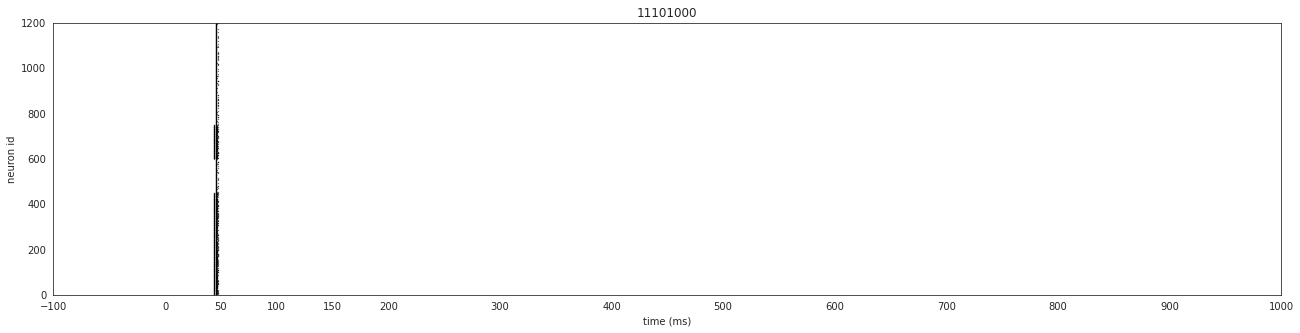

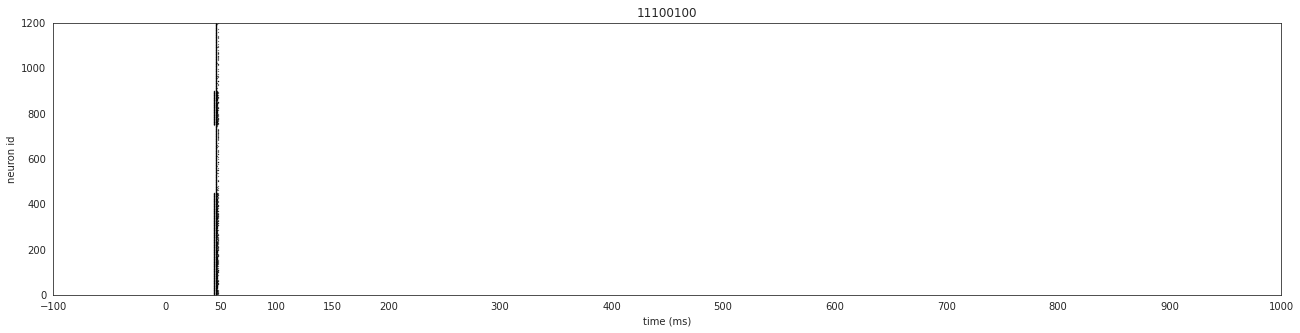

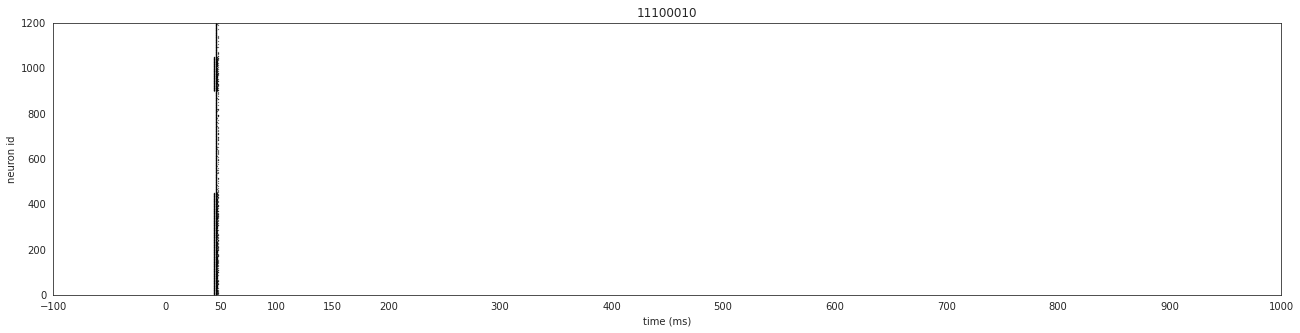

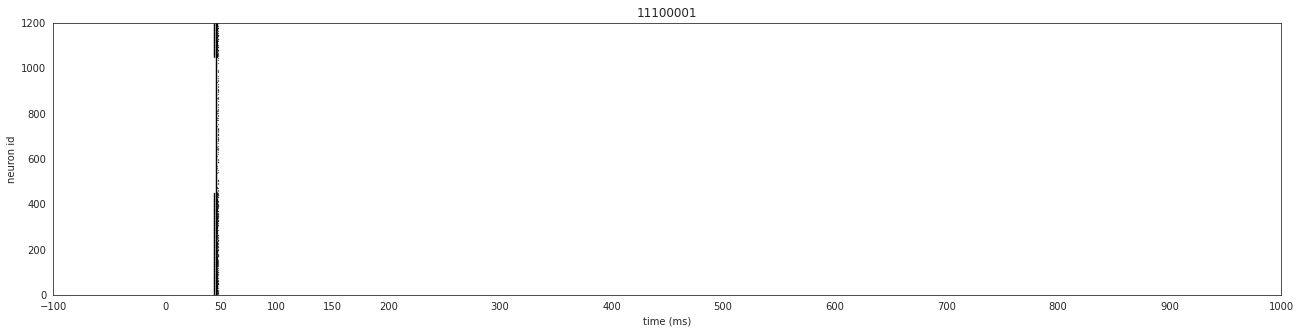

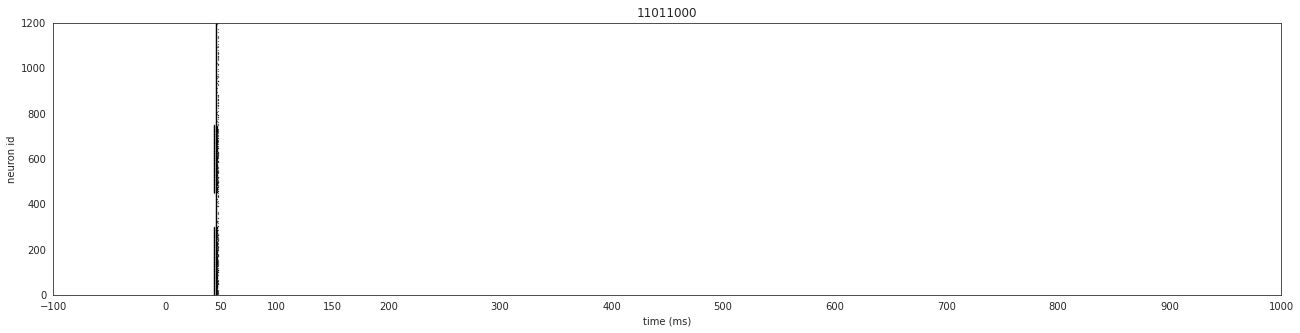

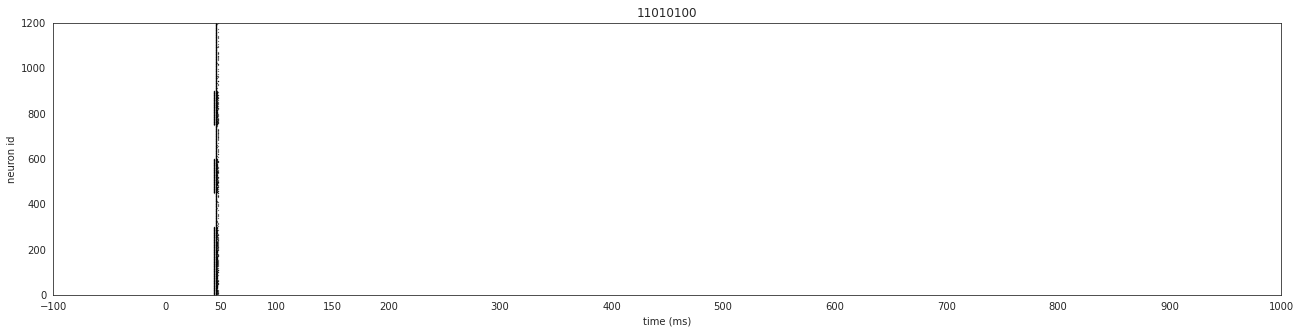

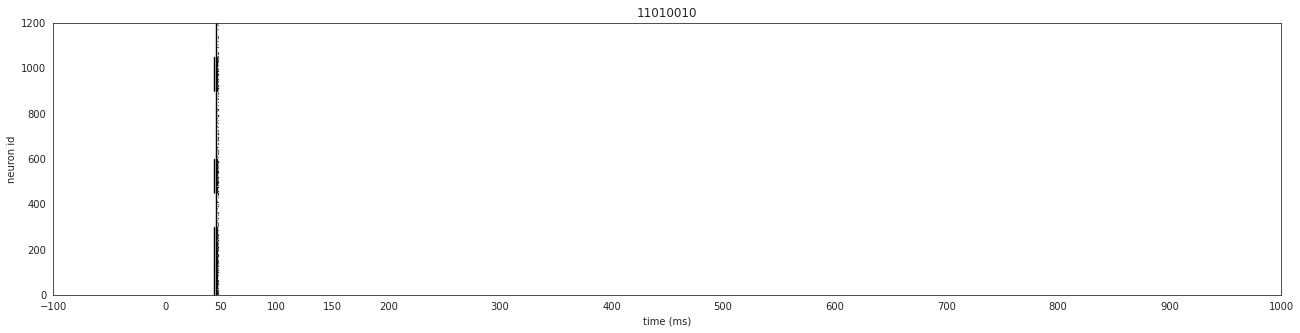

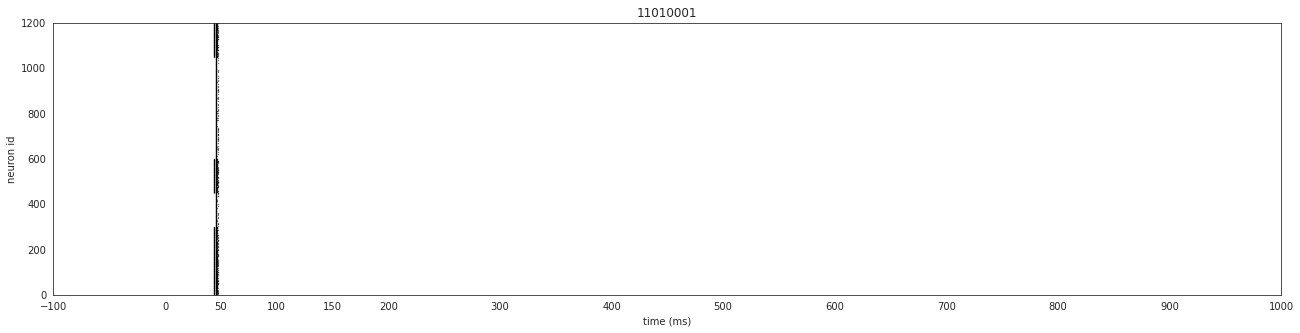

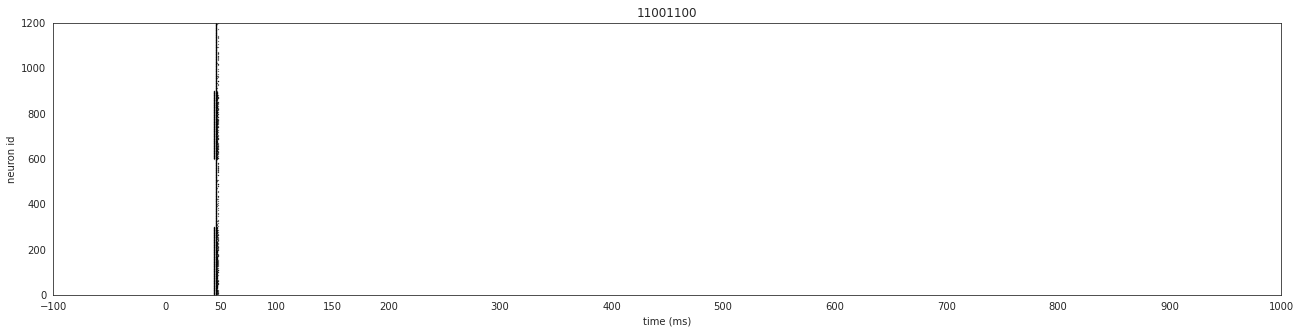

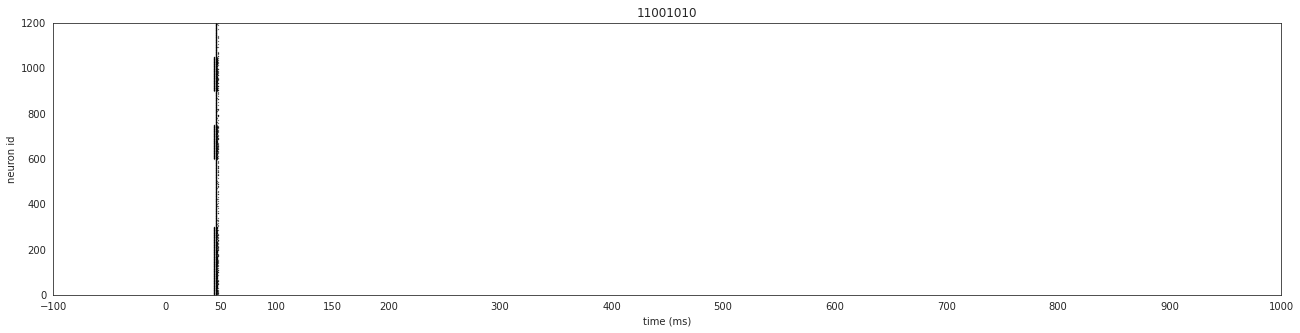

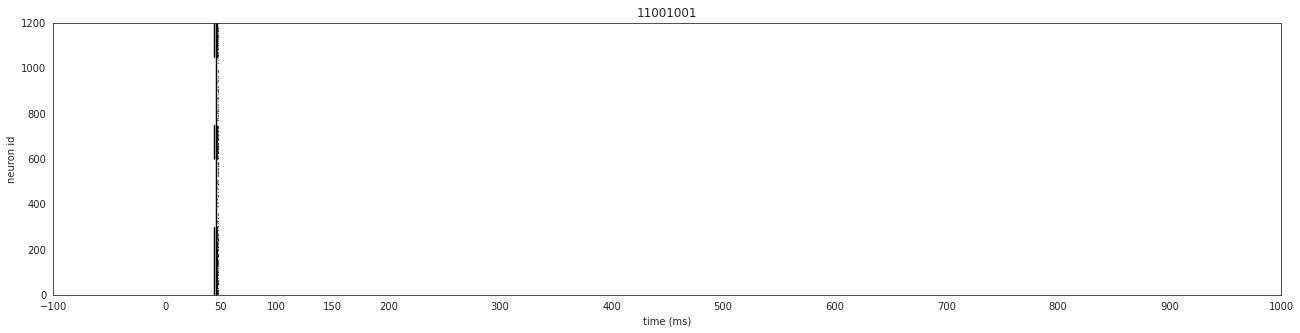

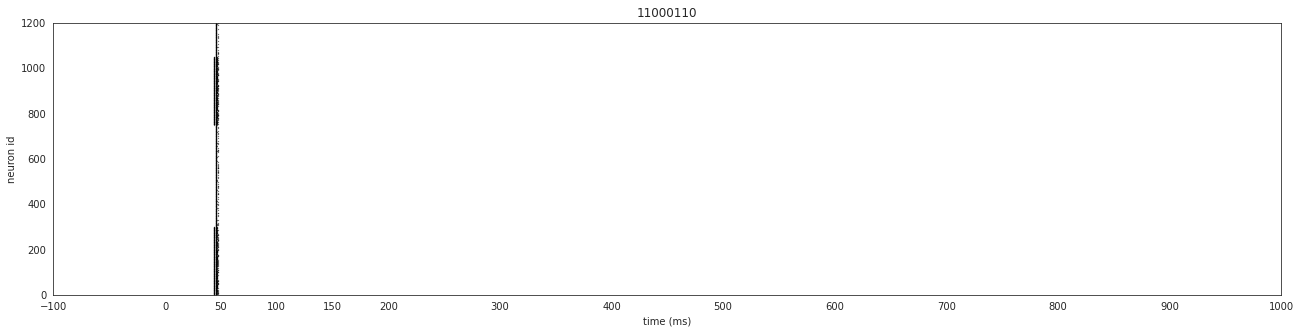

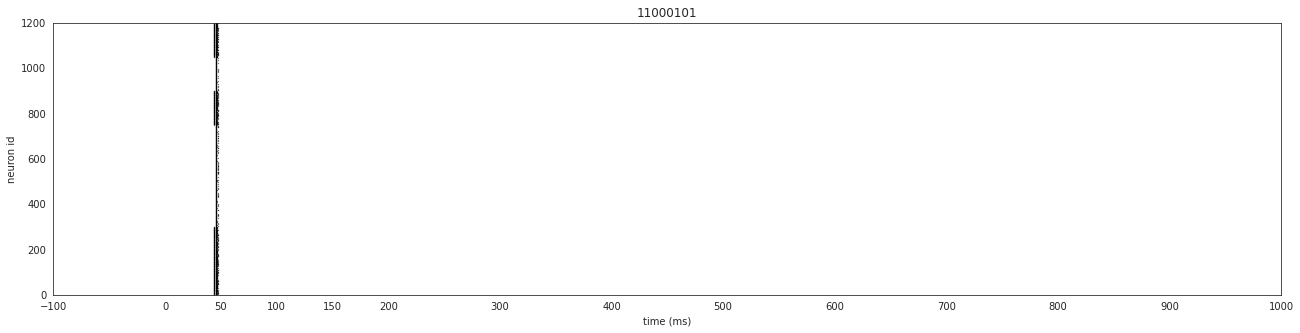

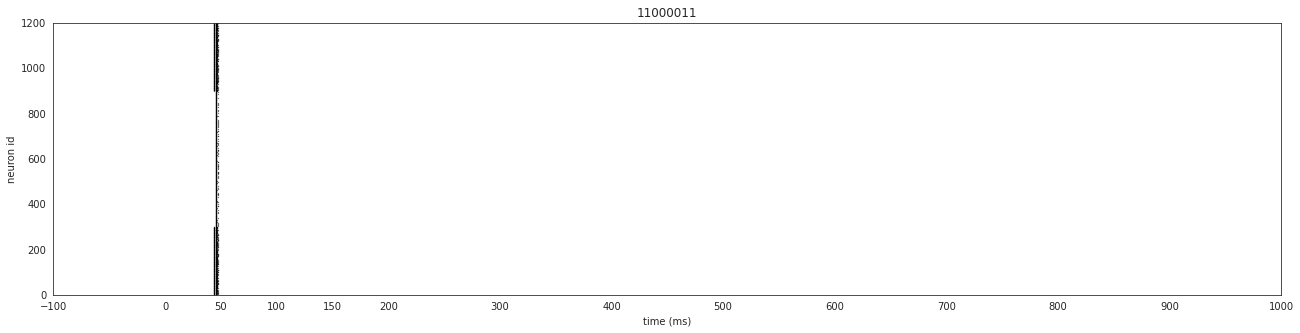

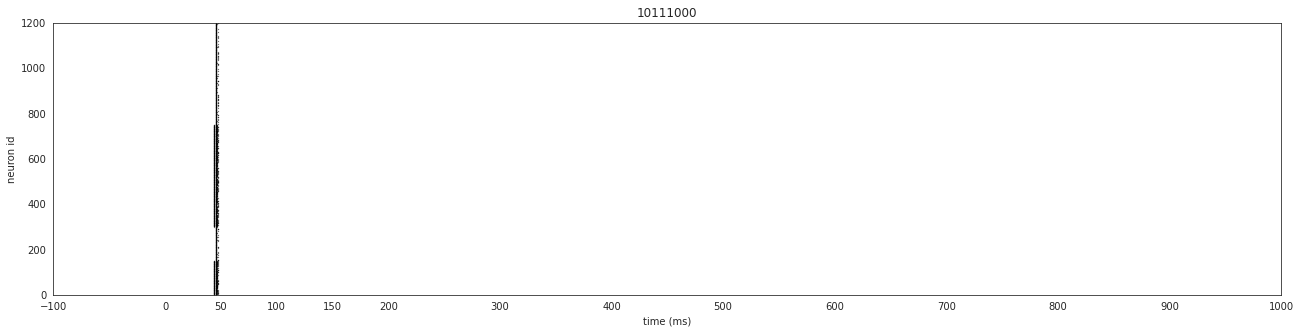

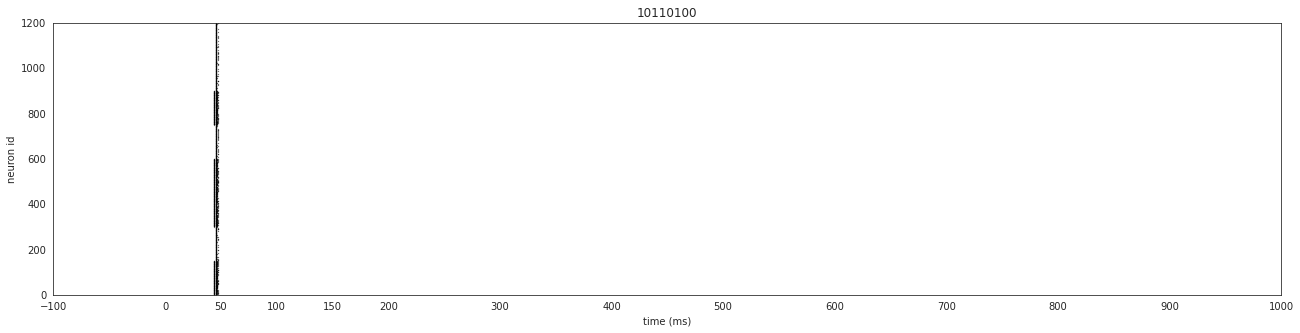

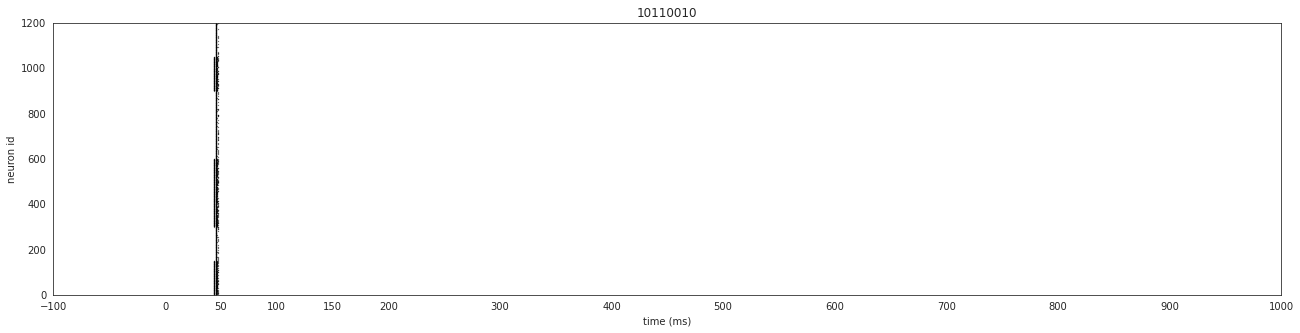

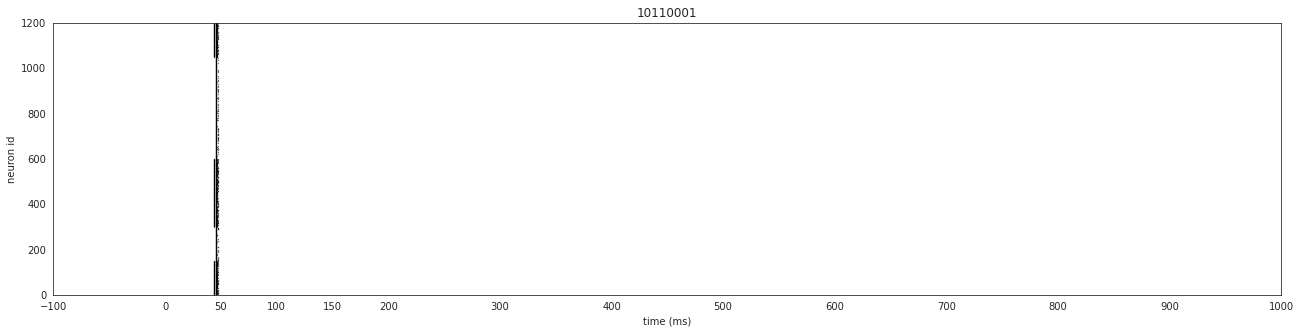

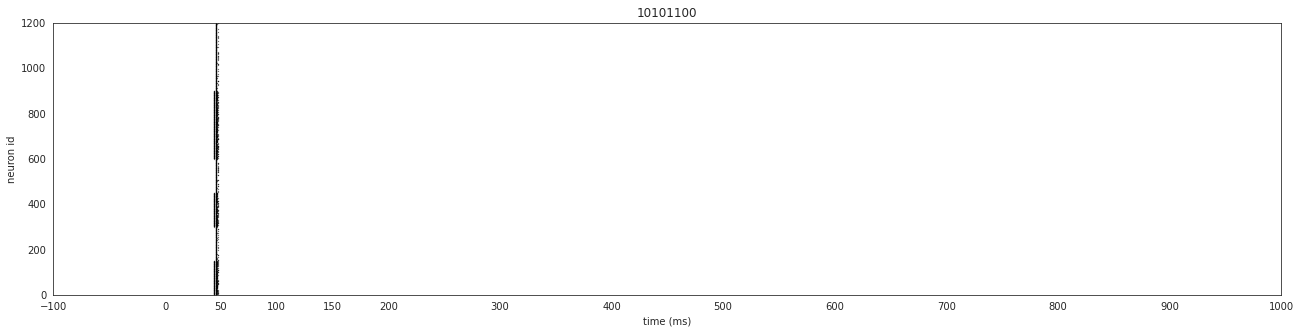

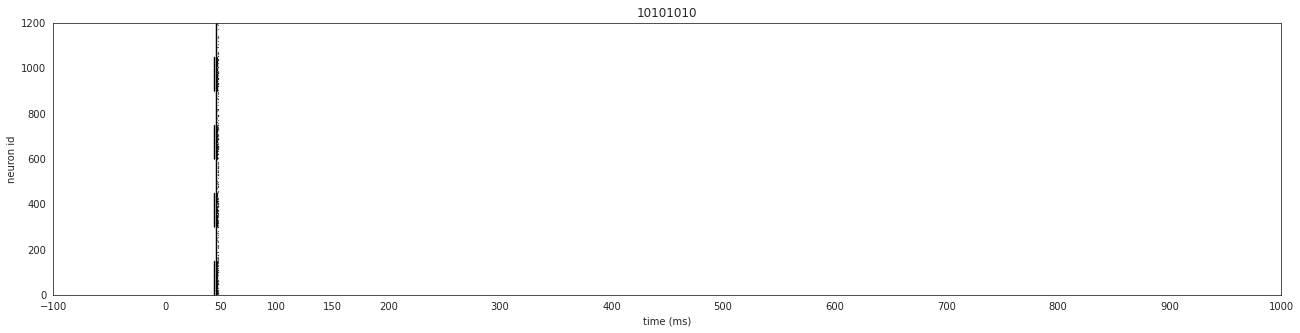

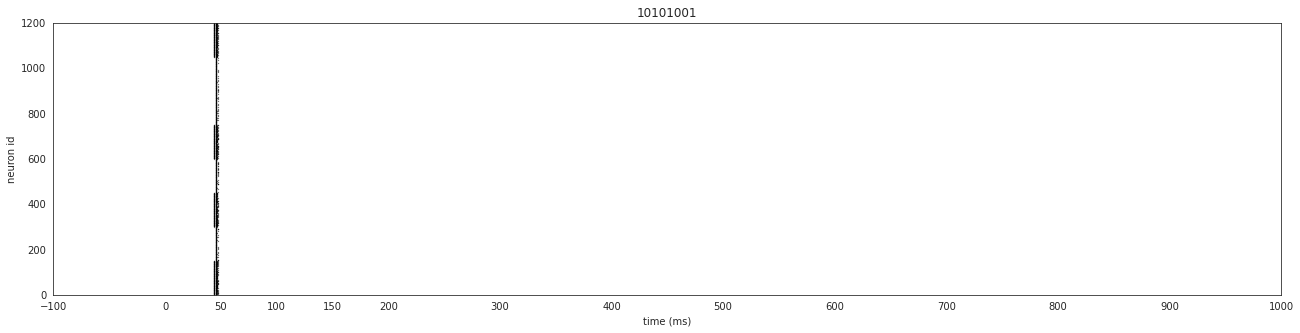

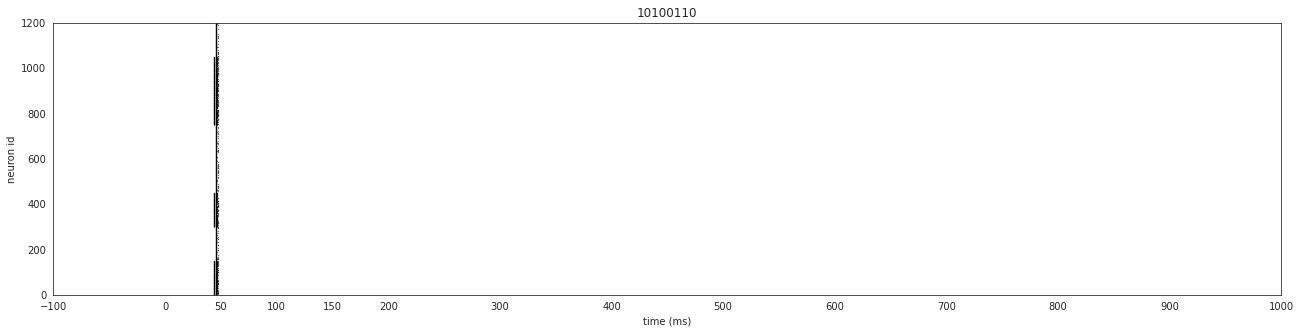

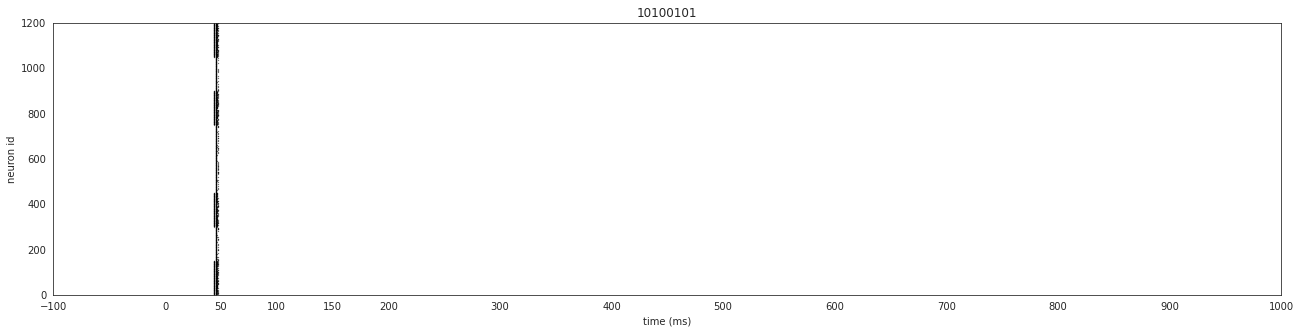

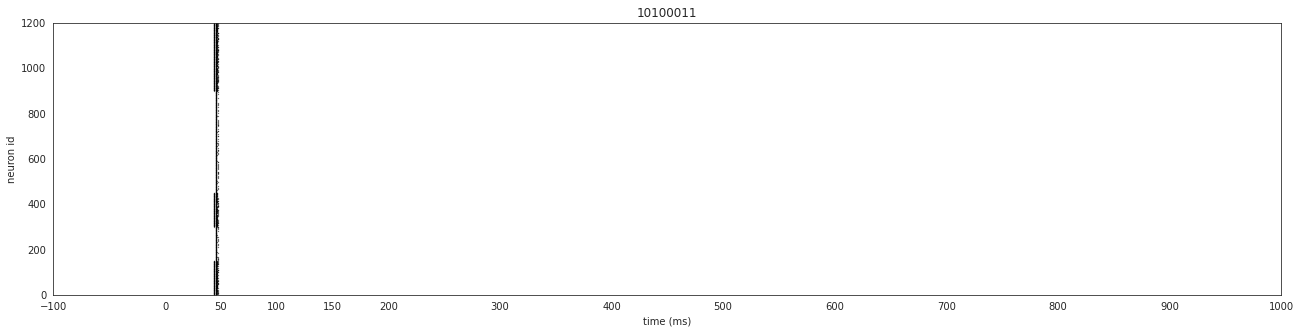

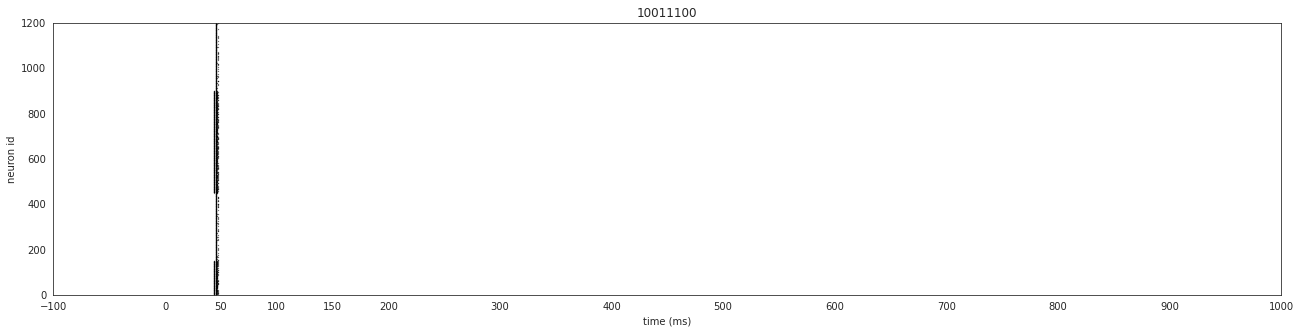

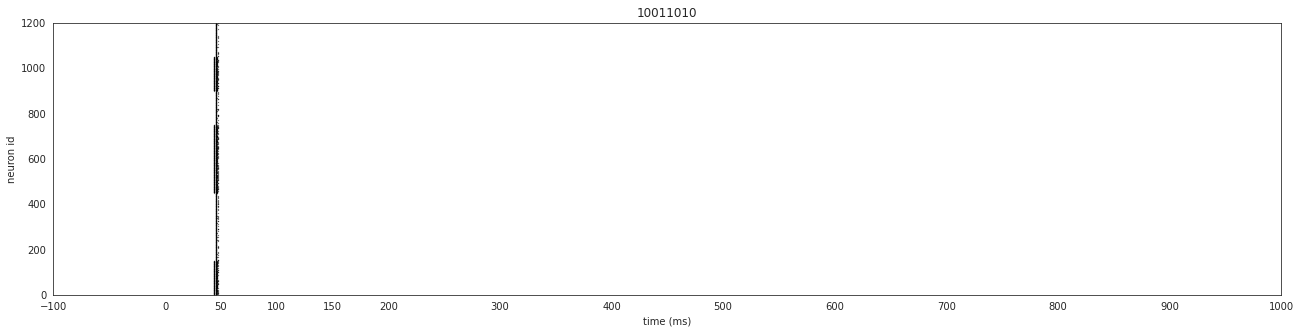

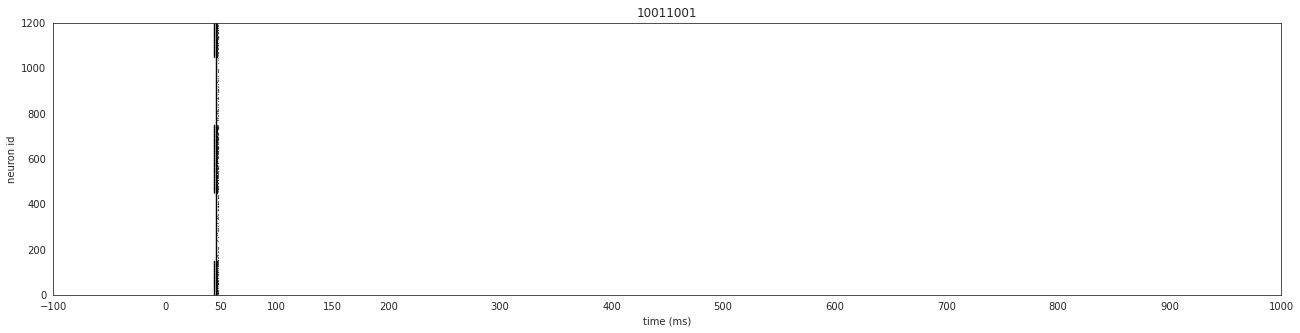

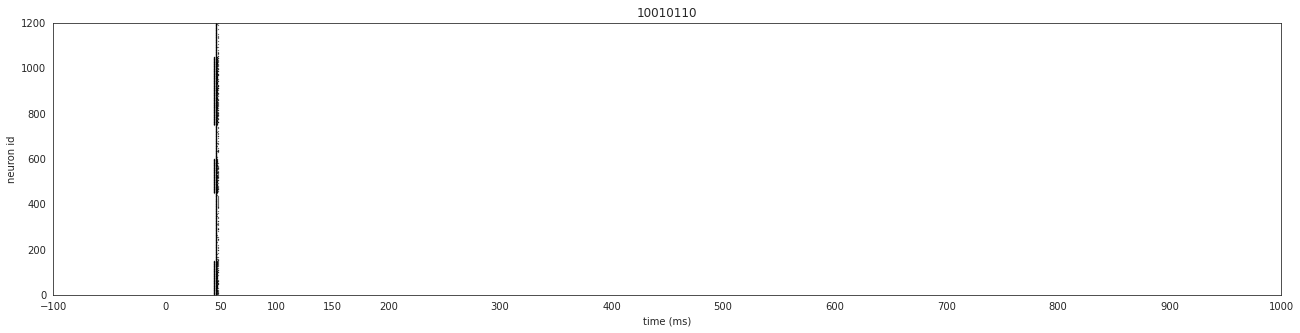

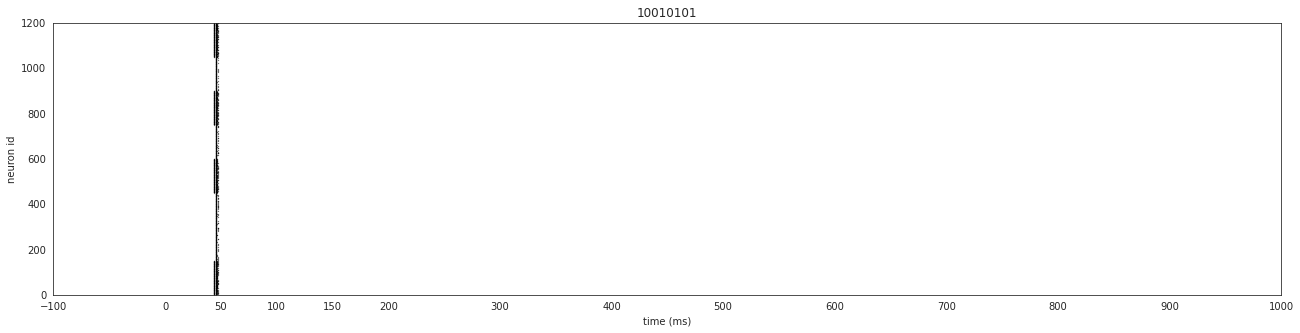

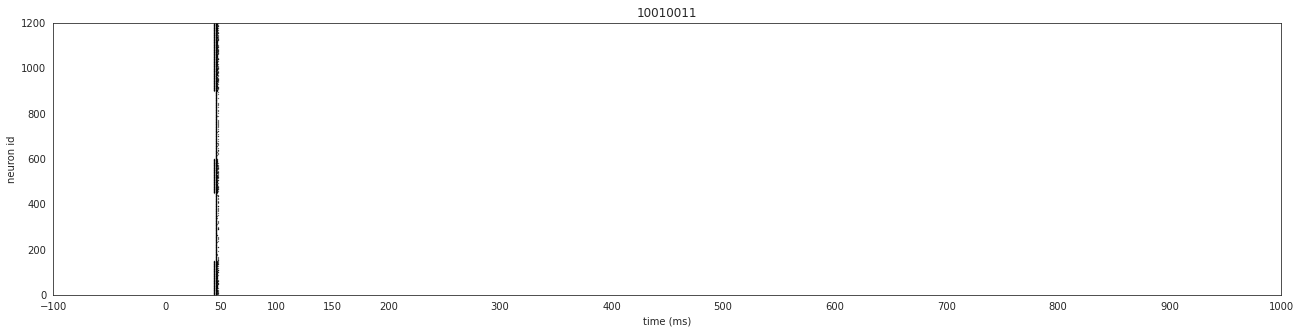

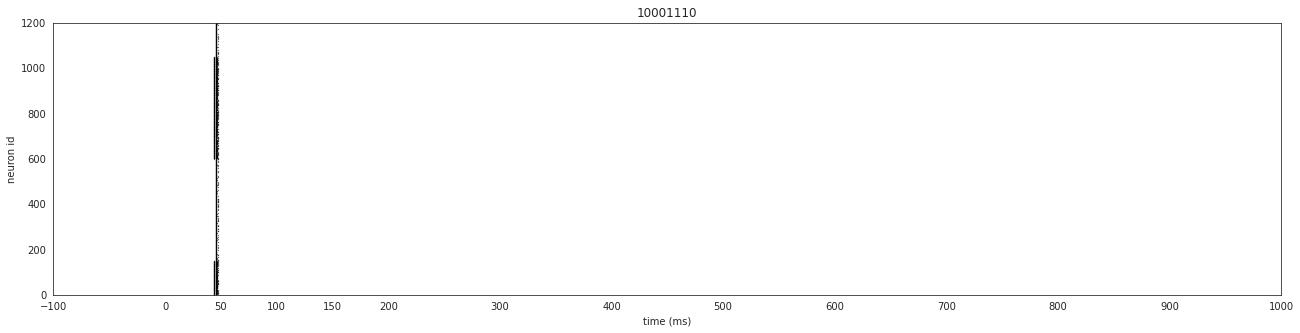

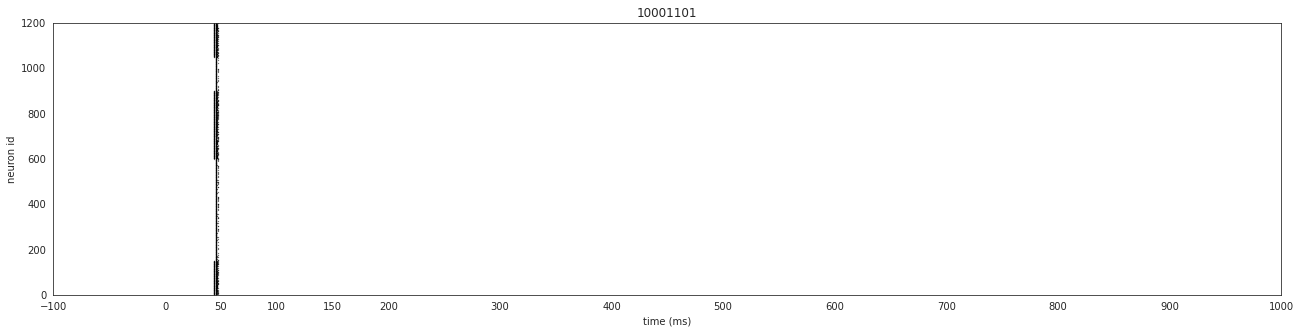

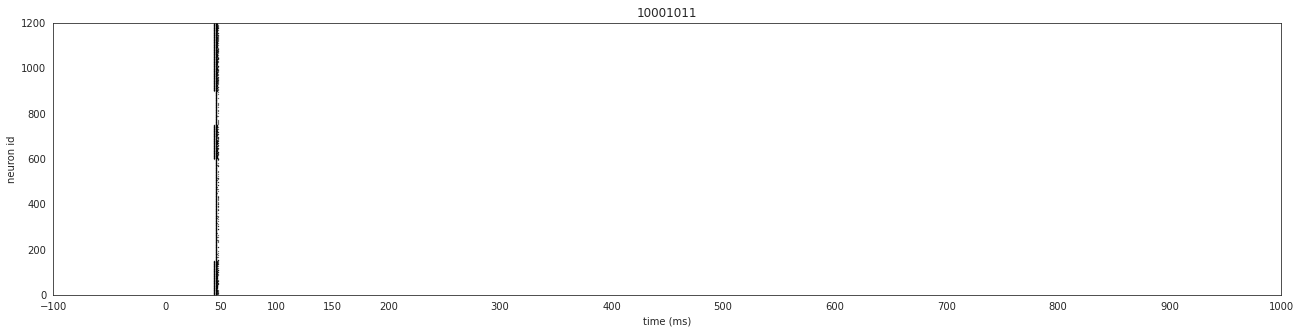

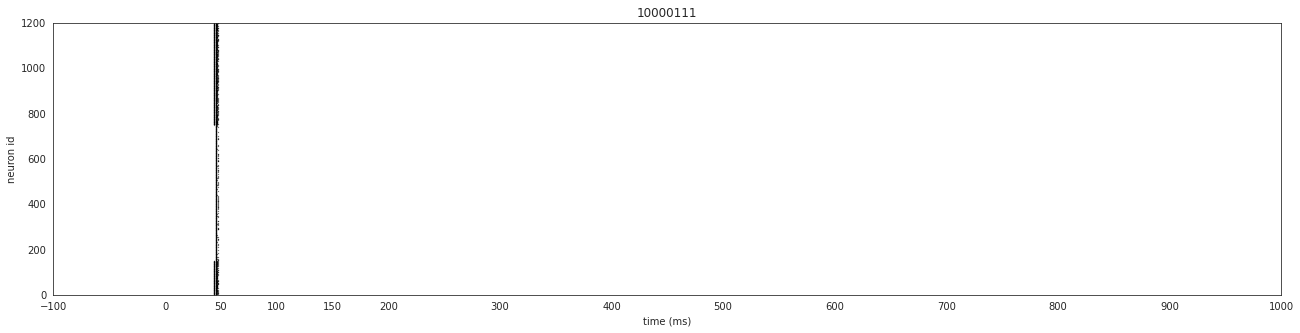

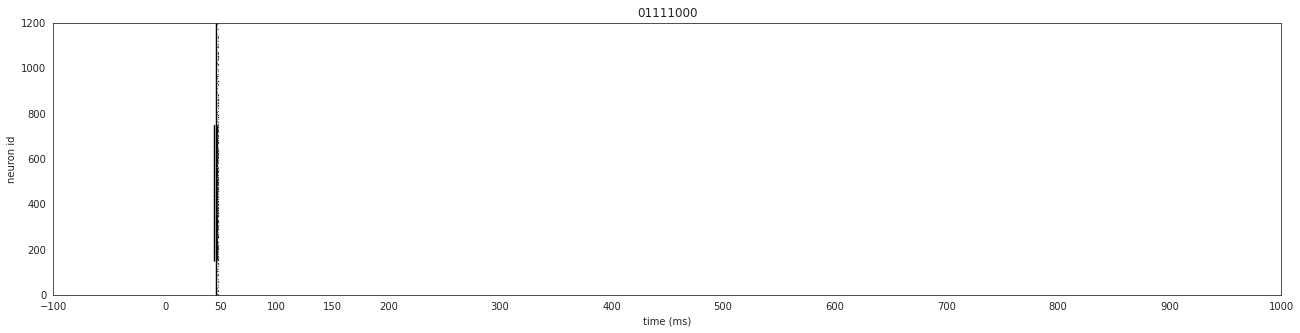

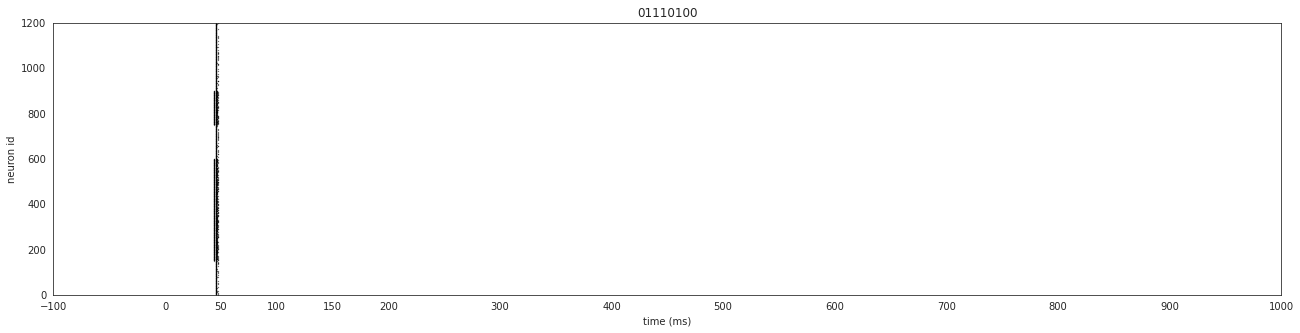

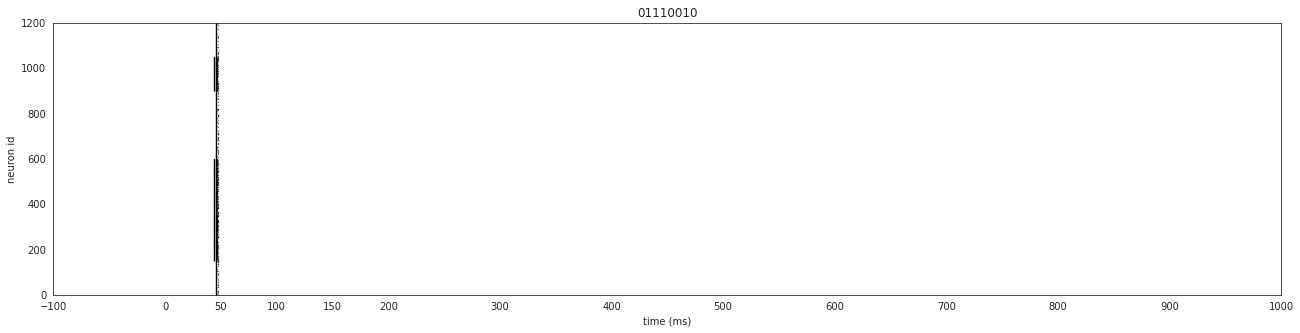

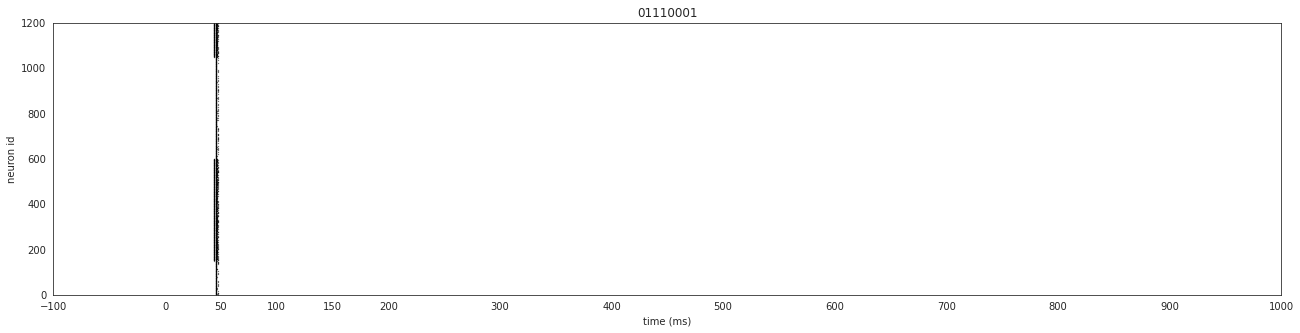

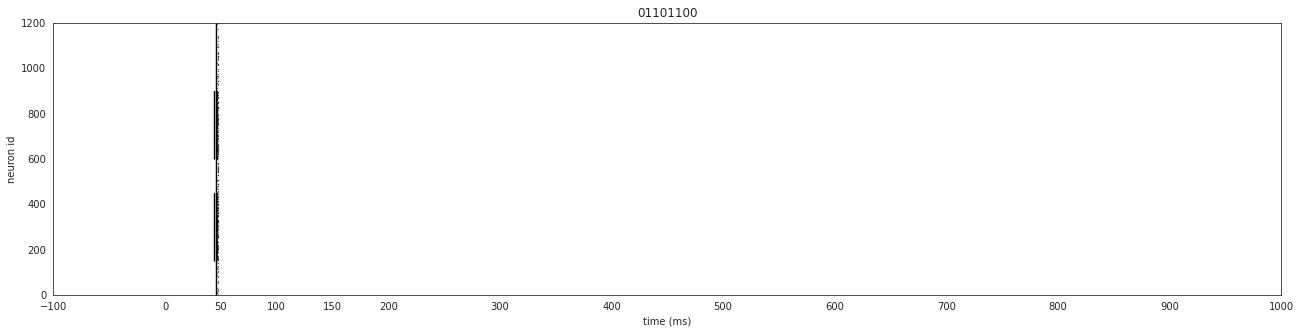

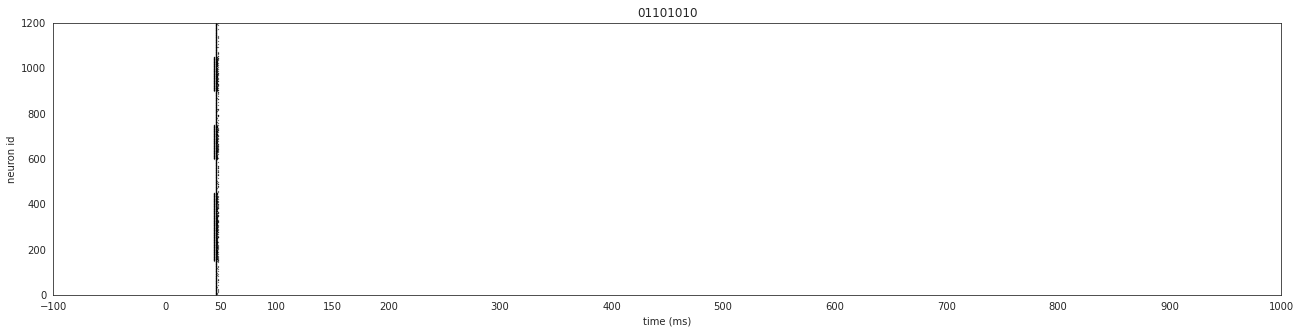

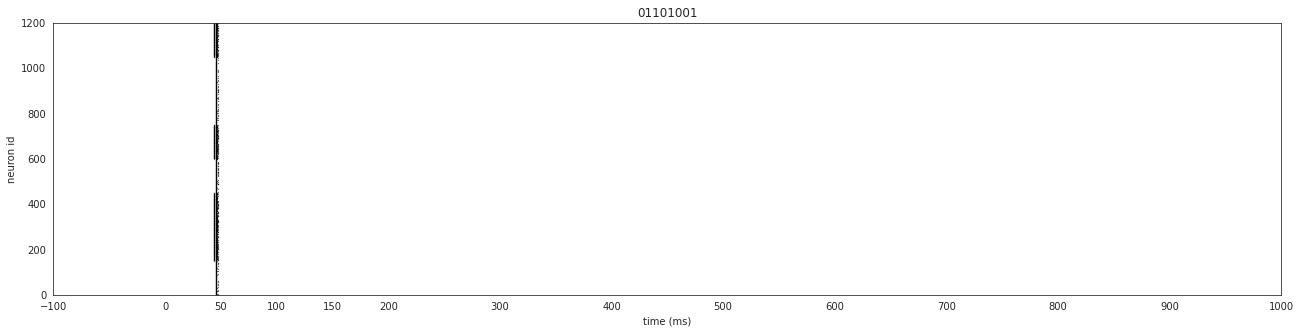

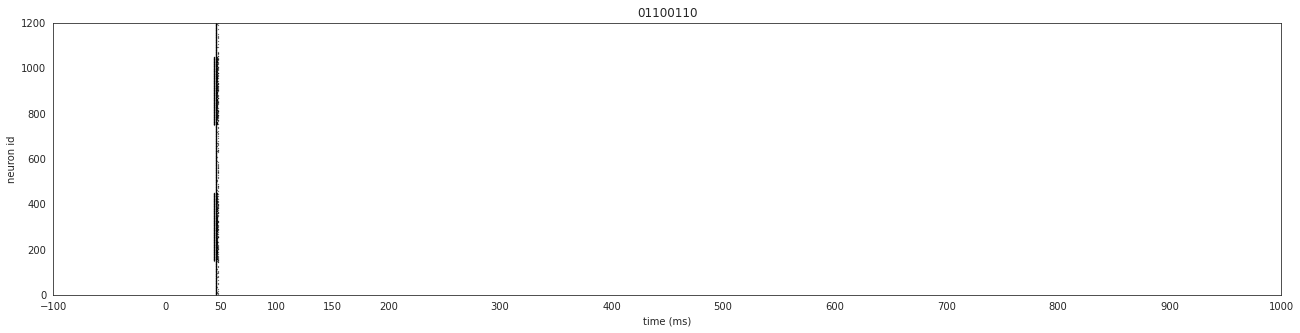

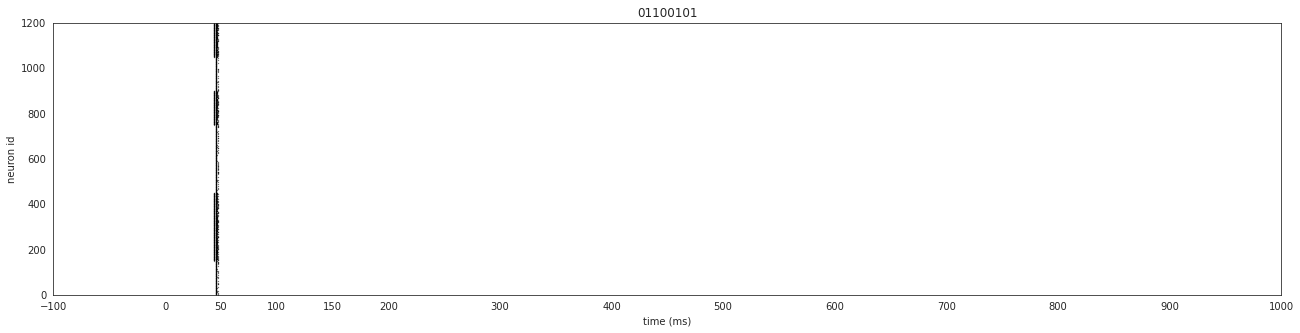

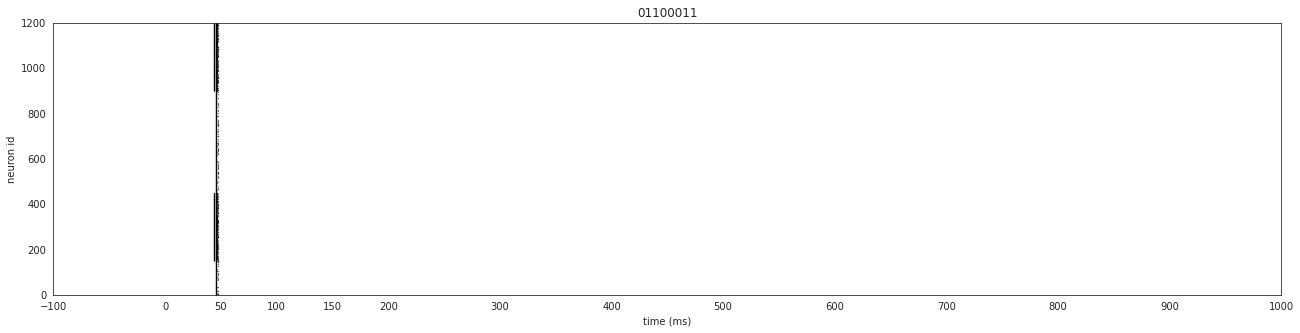

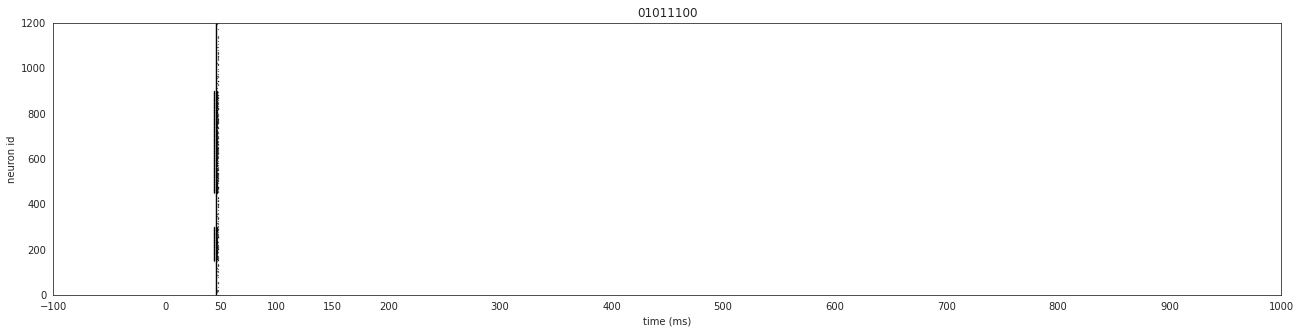

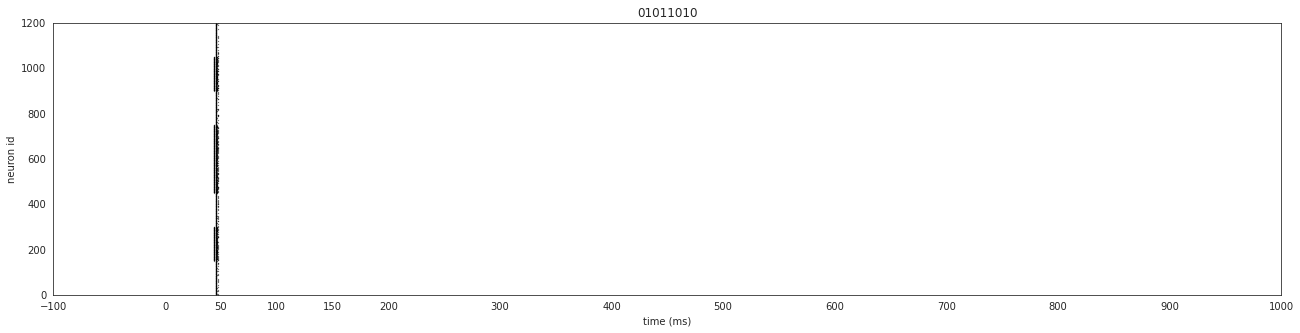

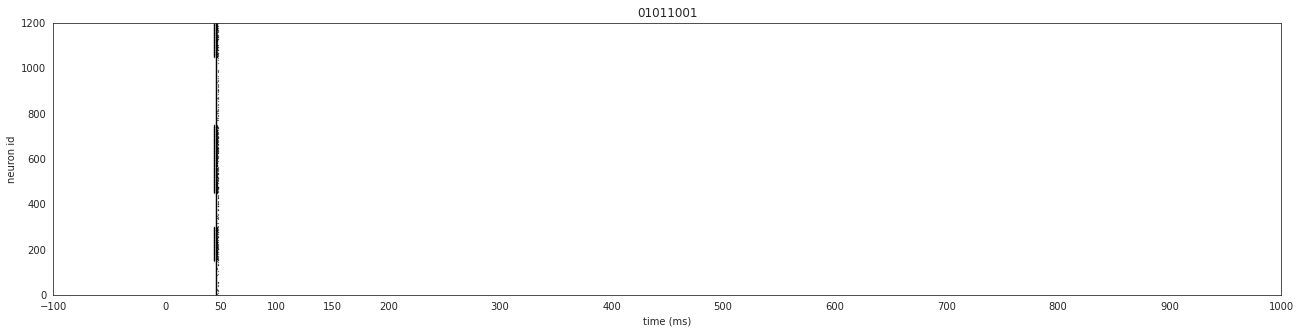

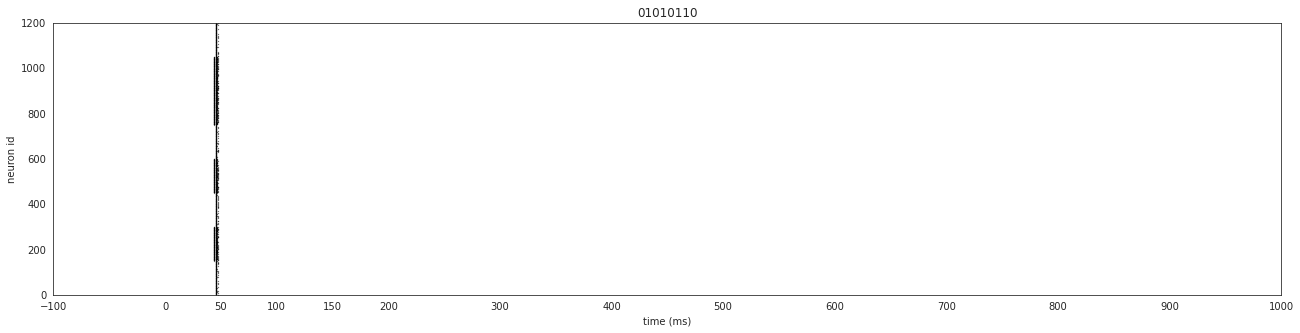

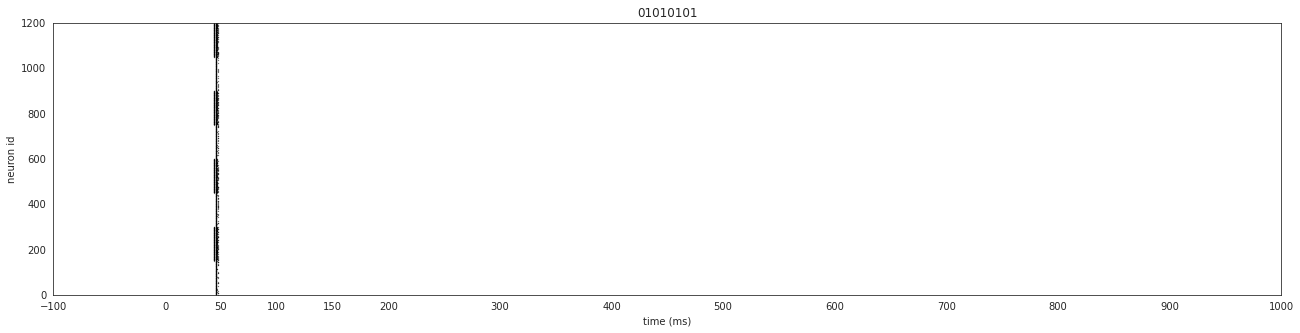

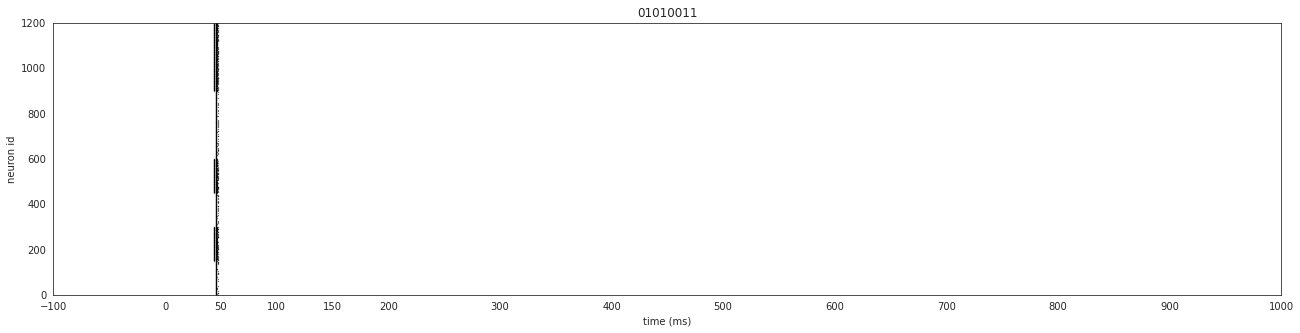

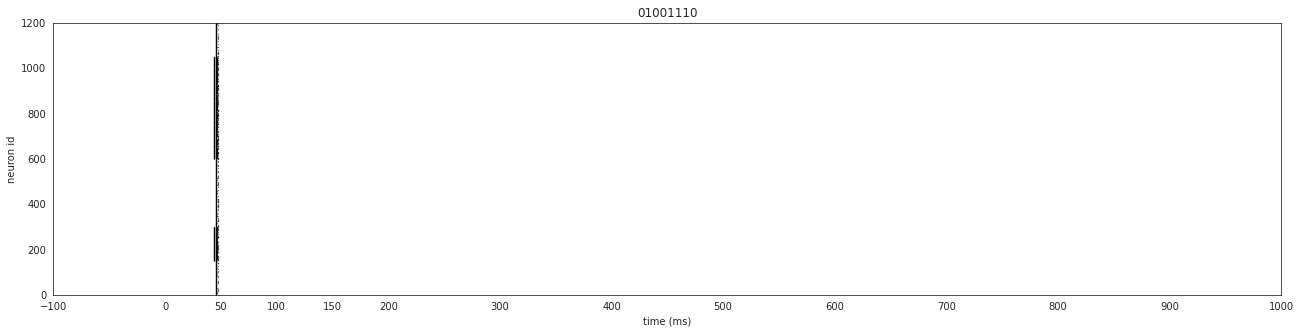

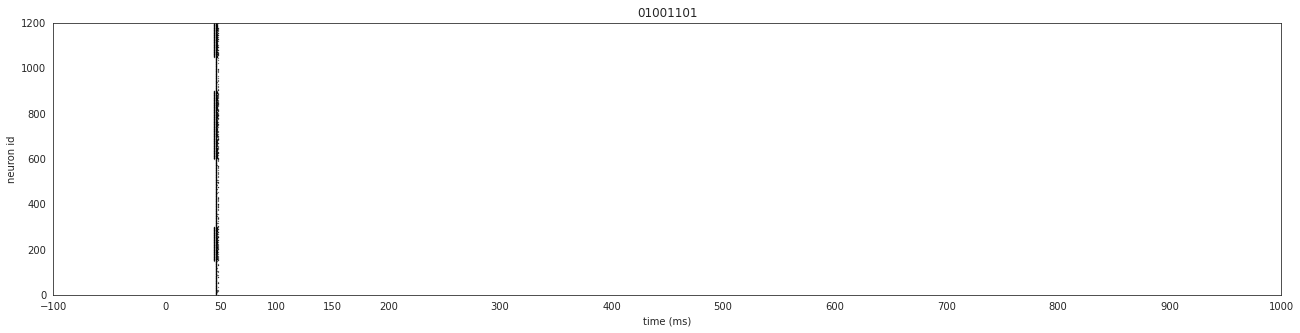

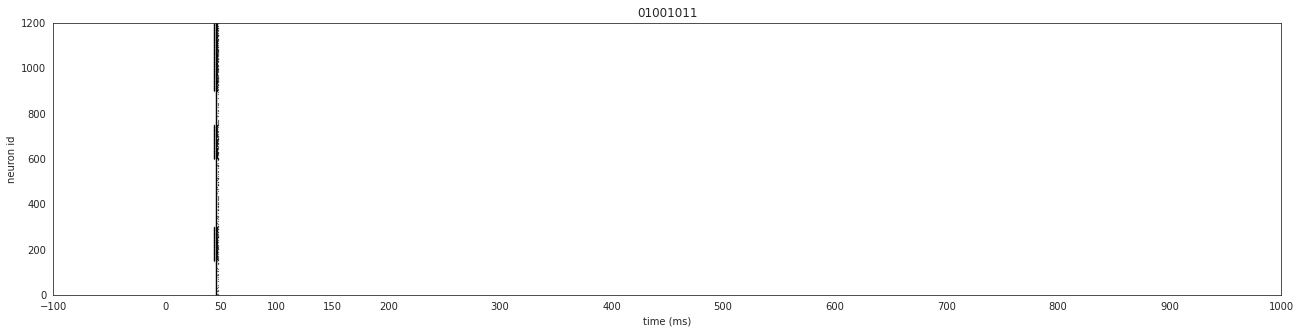

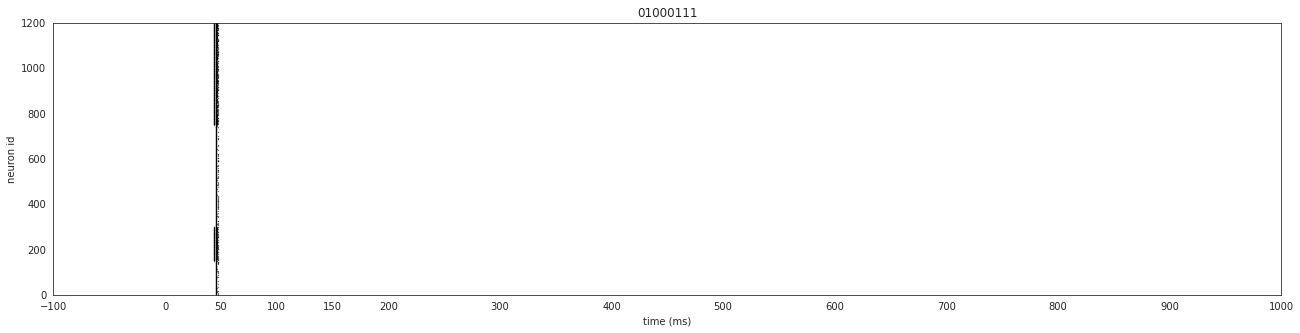

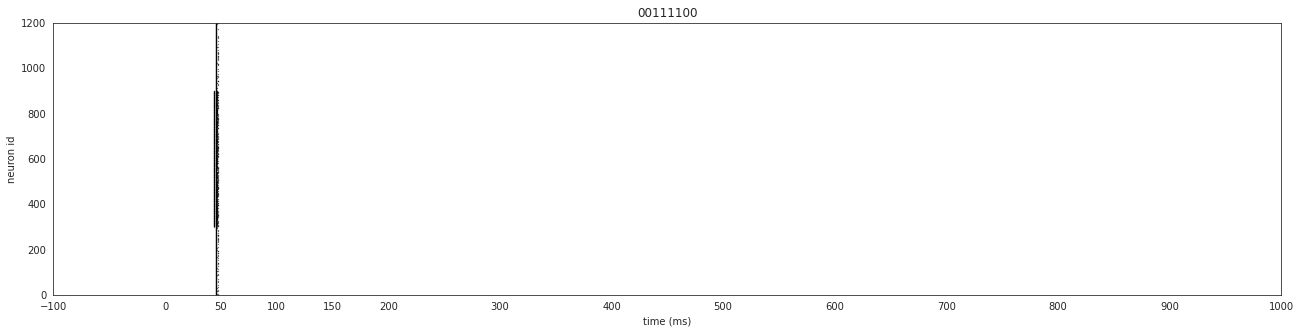

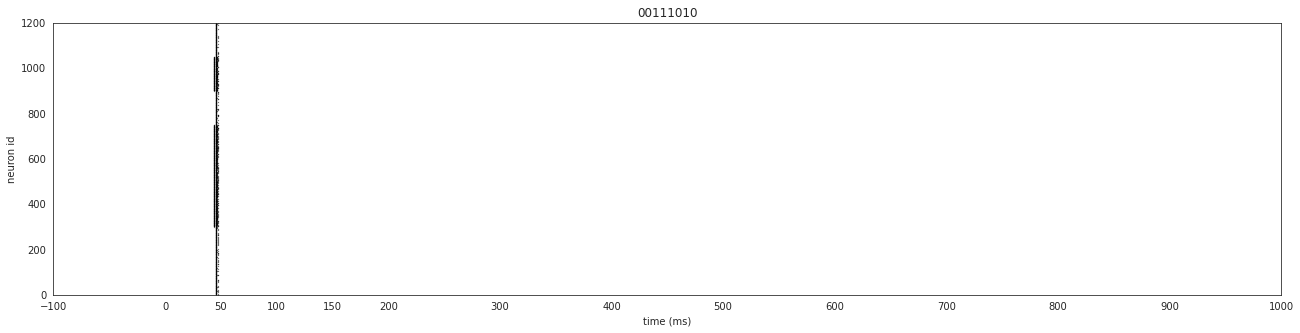

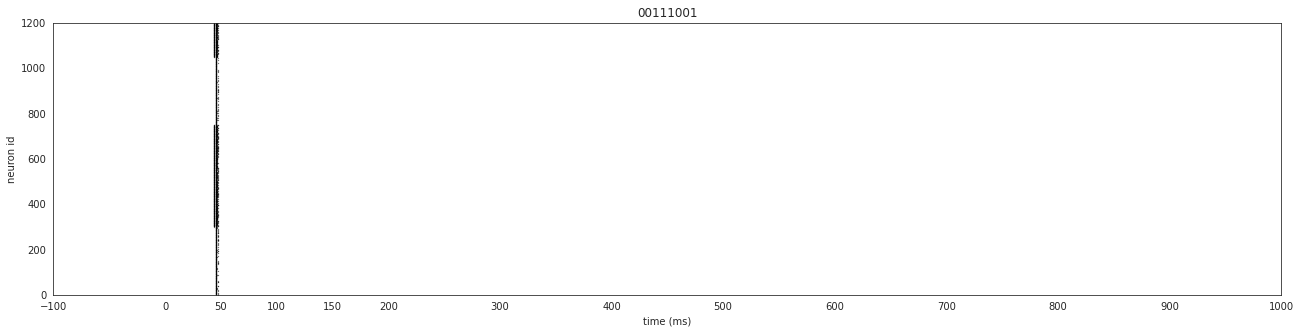

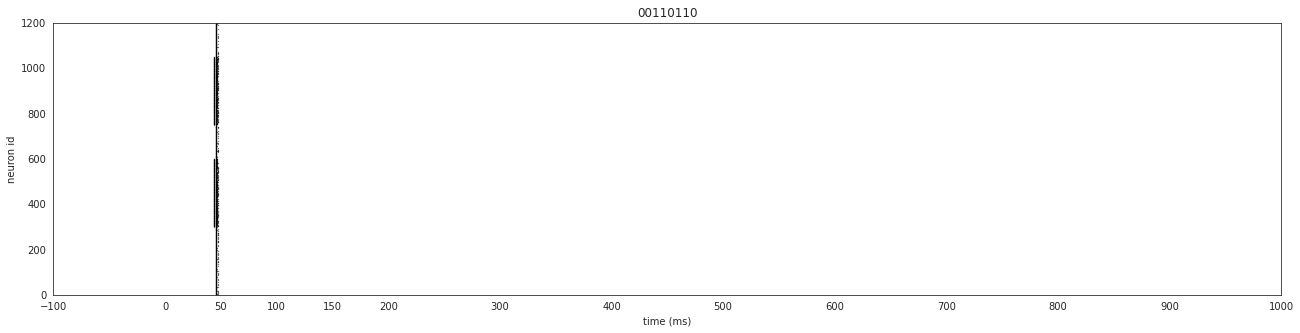

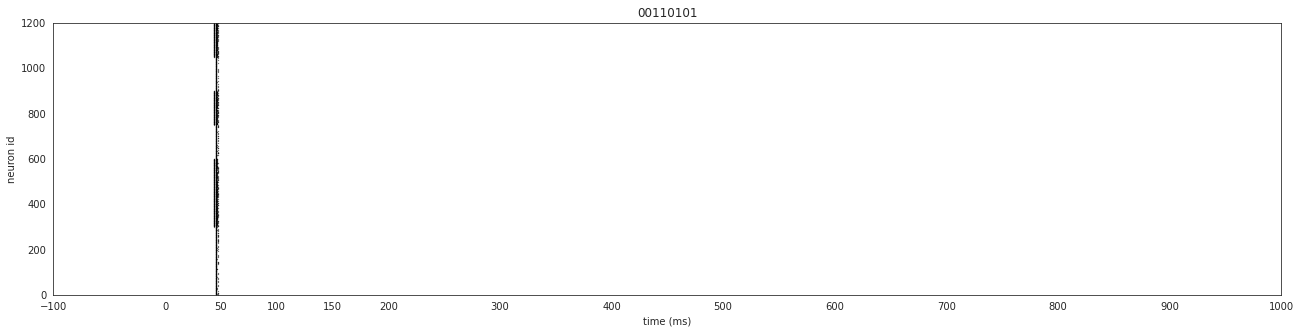

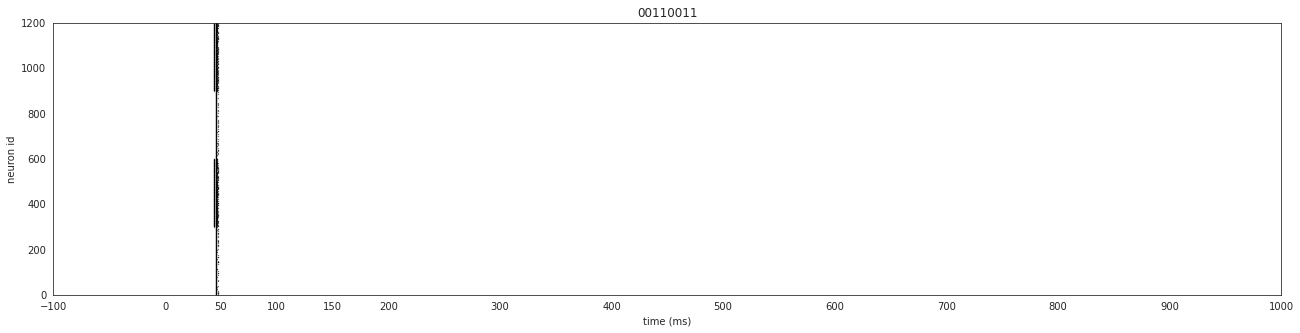

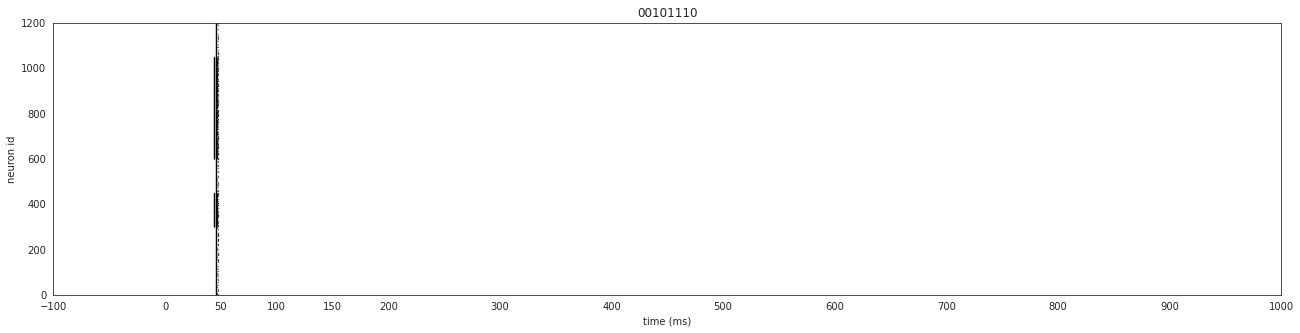

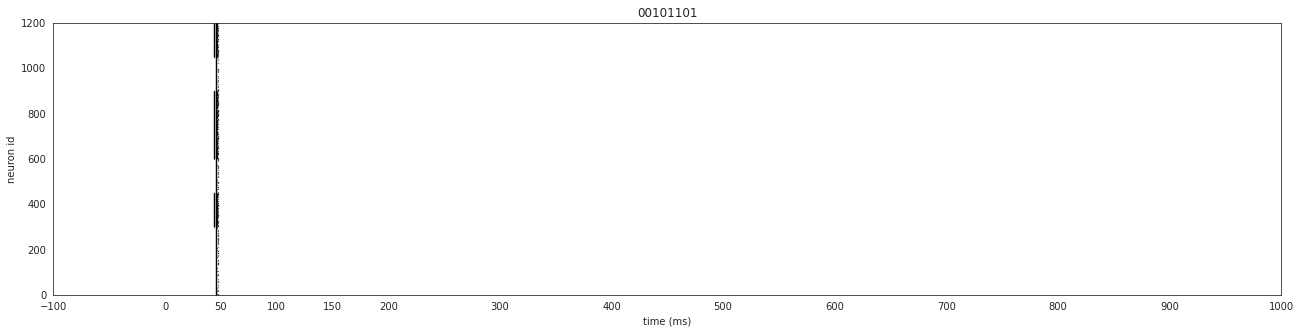

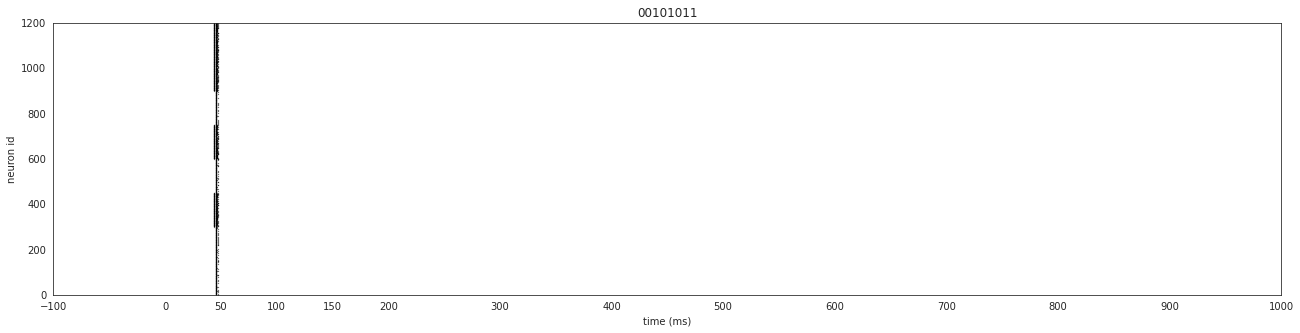

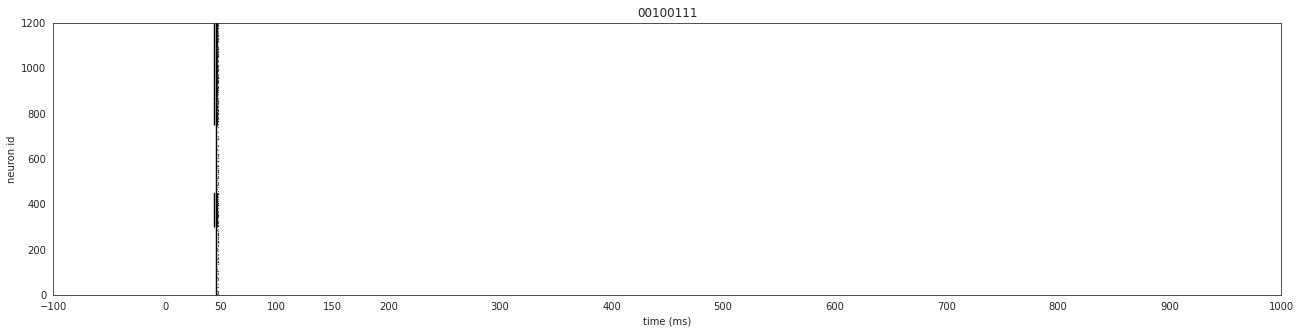

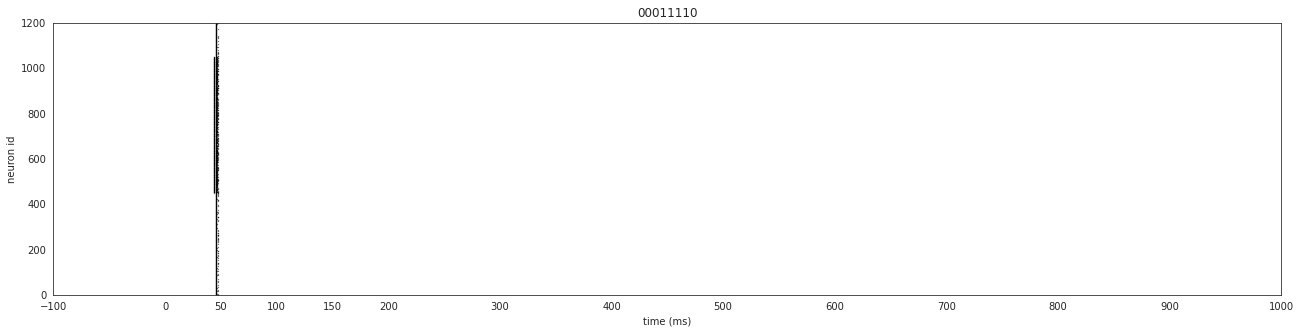

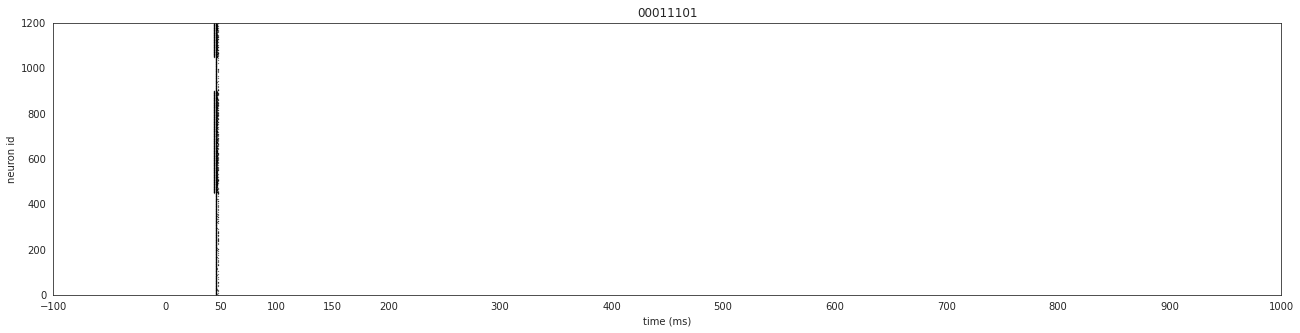

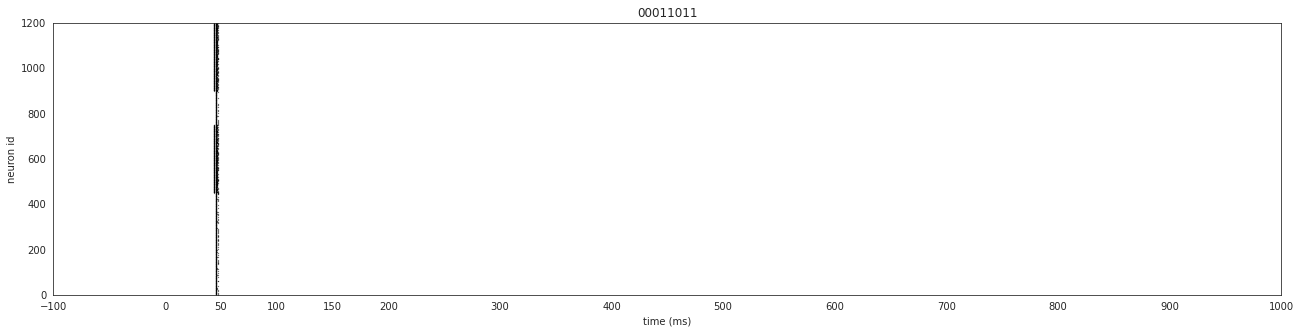

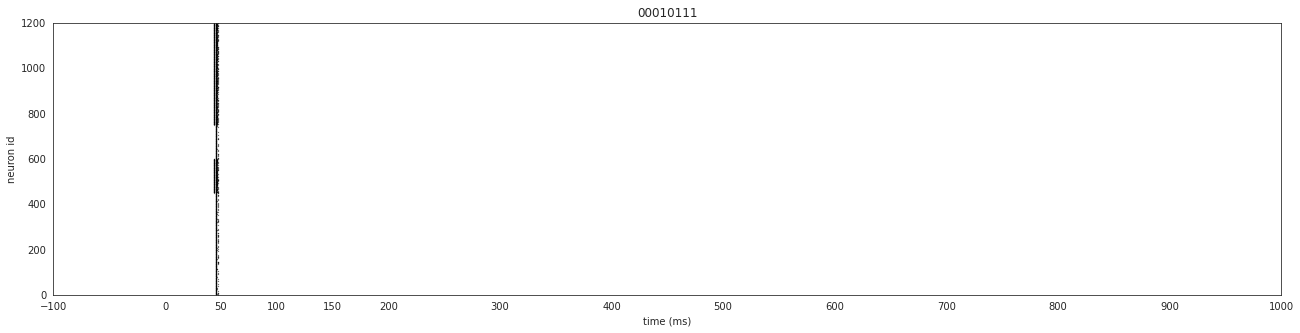

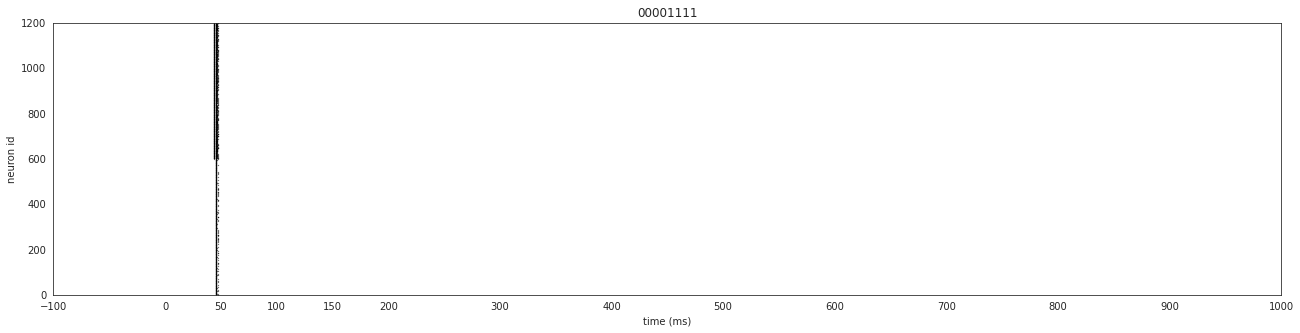

In [74]:
for i, pattern in enumerate(patterns):
    
    f = plt.figure(figsize=(22,5)) 
    plt.title(H.list2str(pattern))
    plt.scatter(spike_times_arr[i],spike_neurons_arr[i], marker='o', s=.05, color='k');
    plt.xlabel('time (ms)')
    plt.ylabel('neuron id')
    plt.axis([-100,500,0, 1200])
    plt.xticks([-100, 0, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) # add some extra ticks for clarity
    #plt.savefig(path+str(H.list2str(pattern))) uncommment to save figures

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


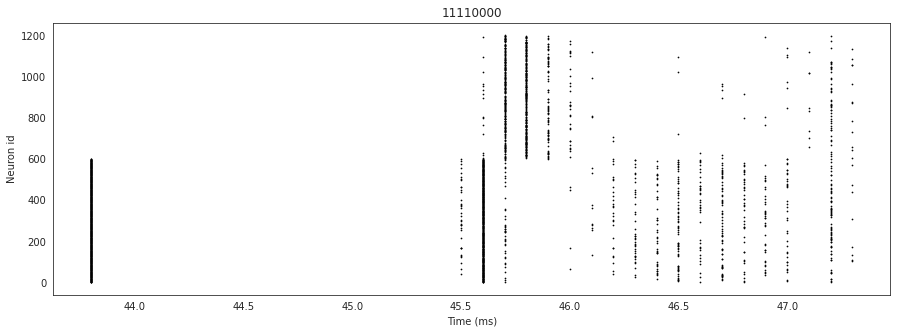

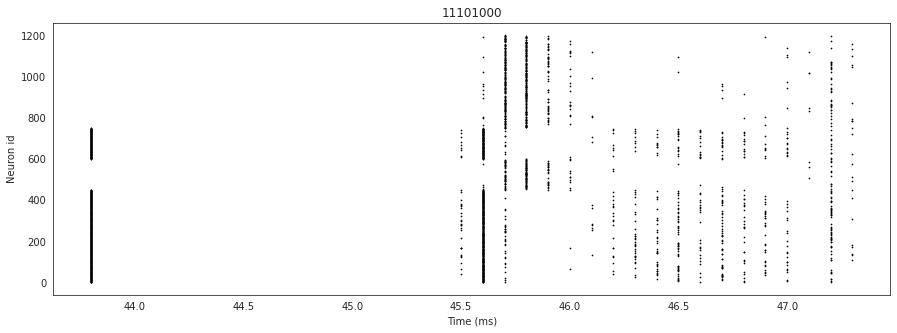

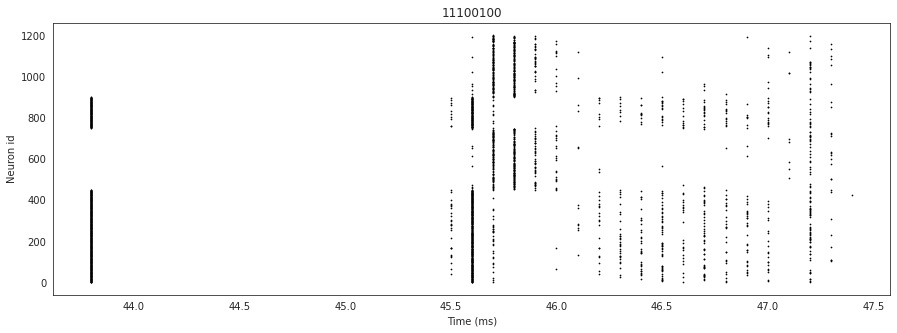

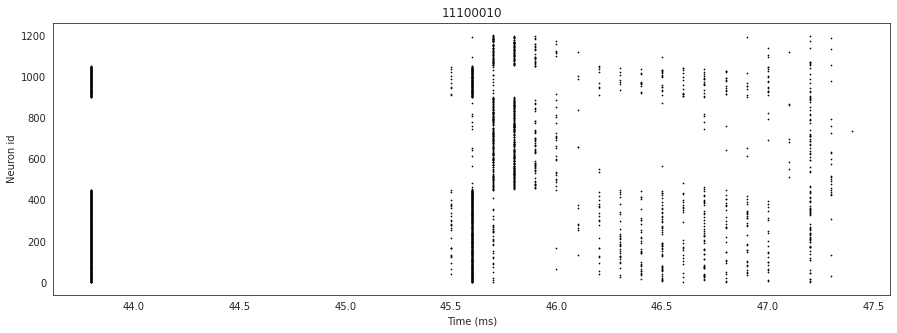

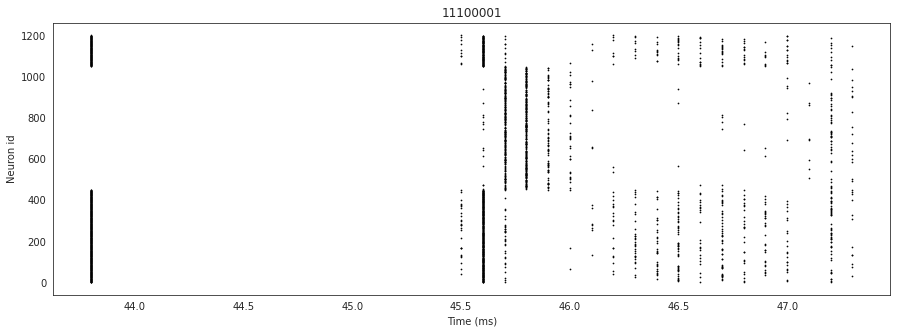

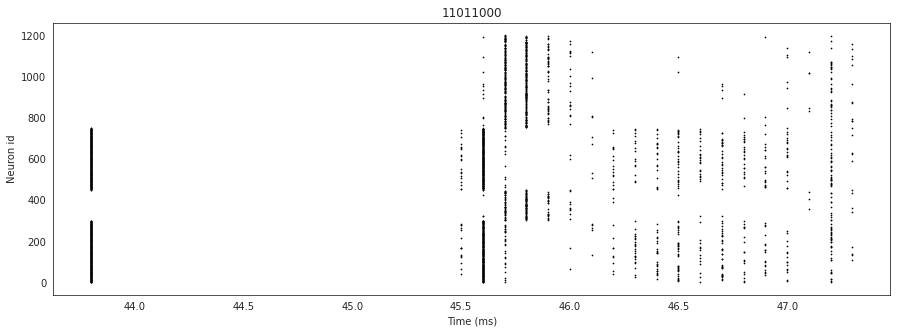

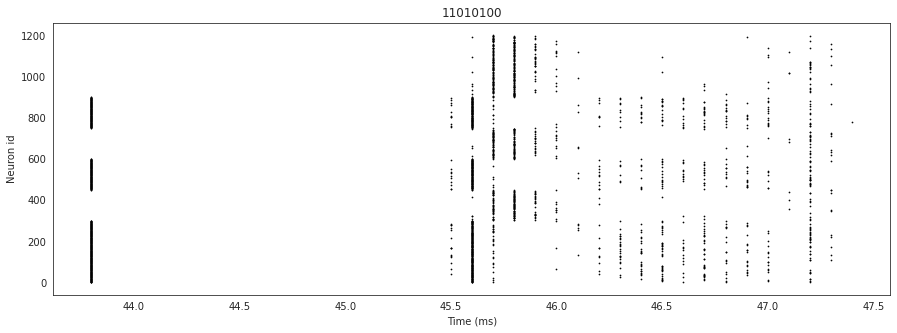

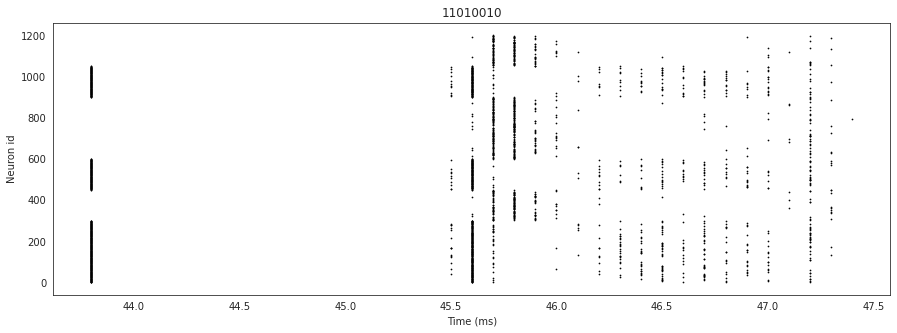

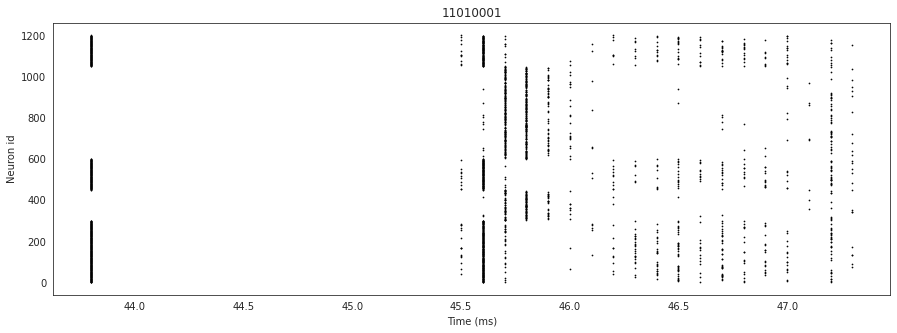

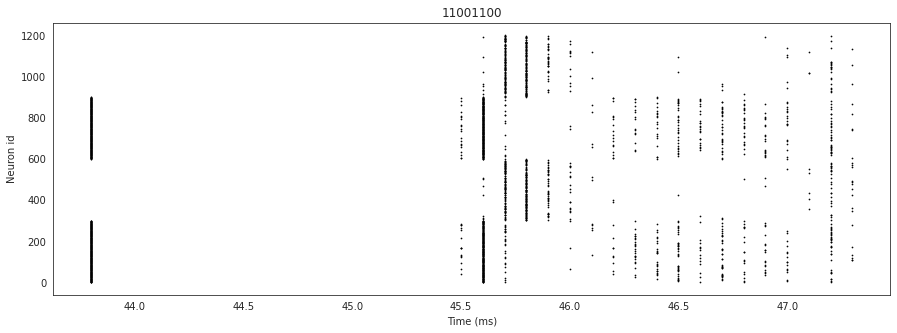

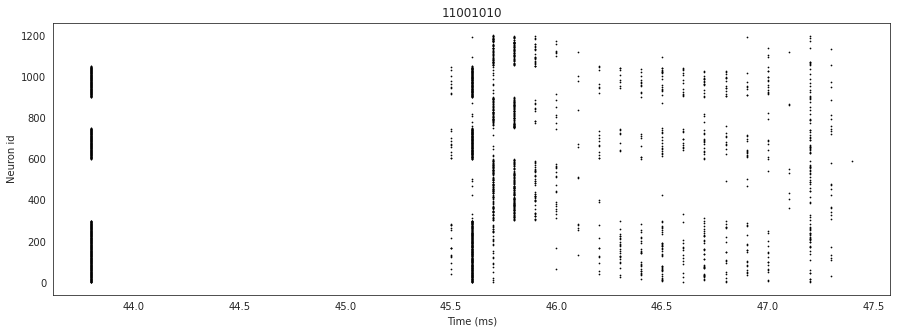

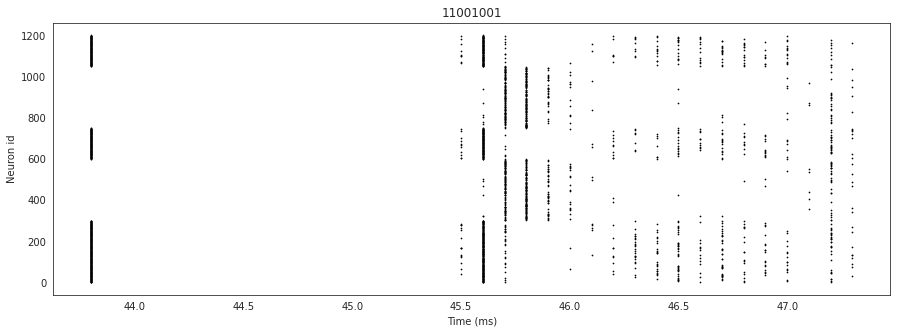

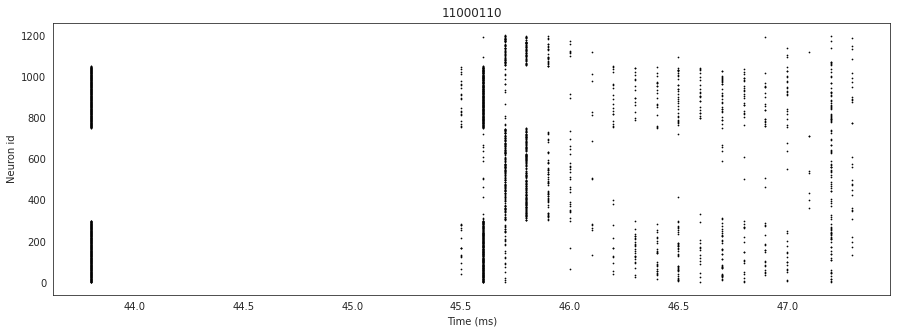

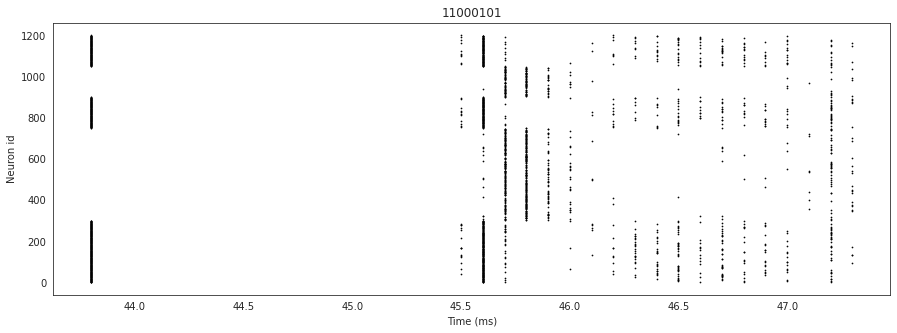

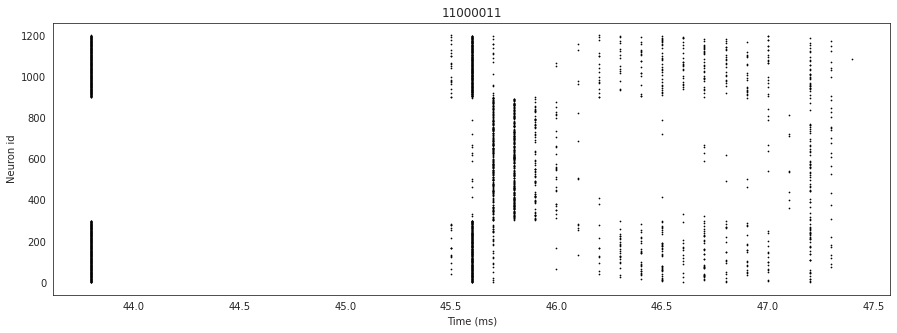

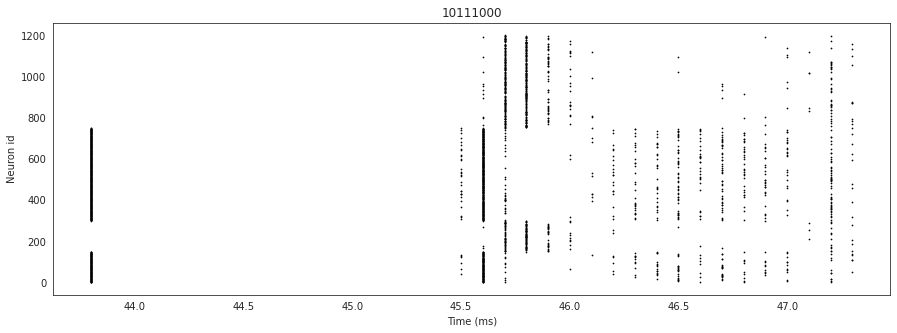

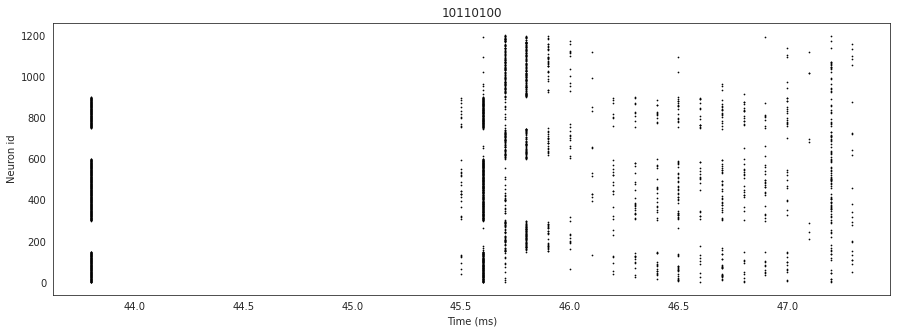

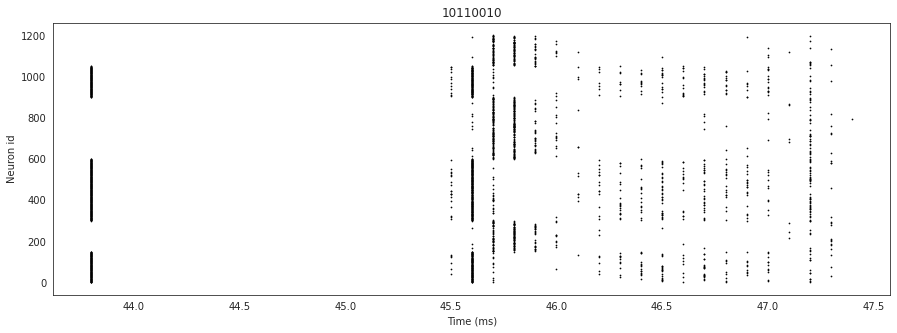

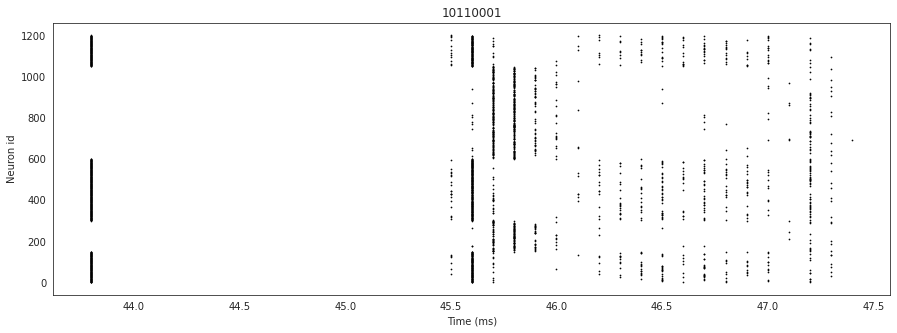

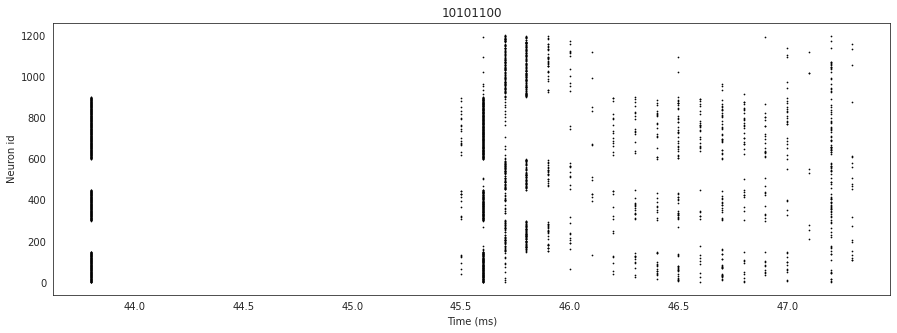

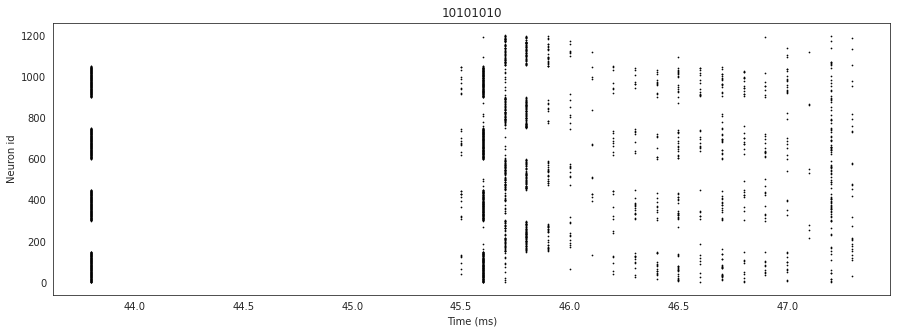

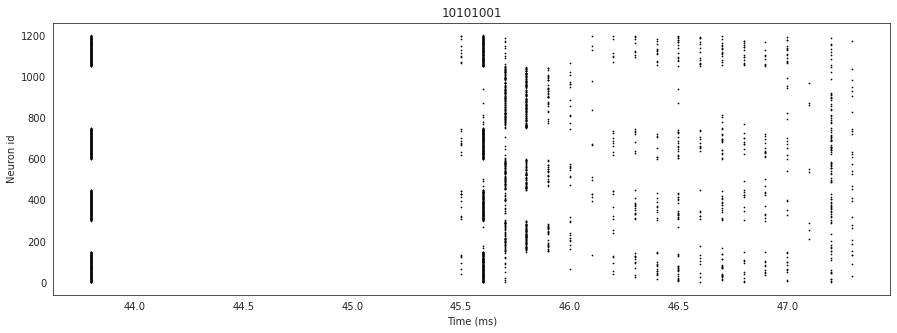

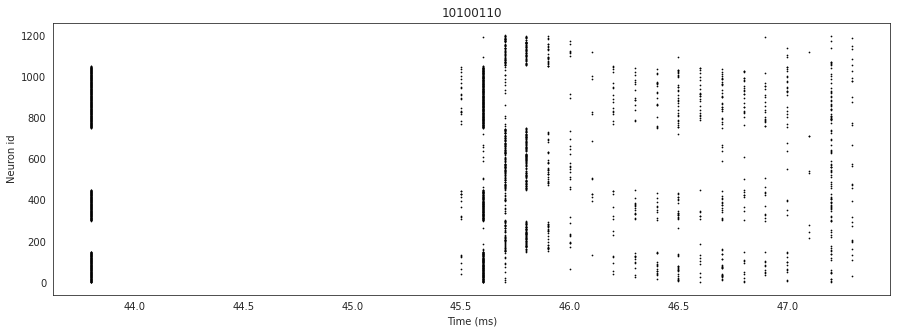

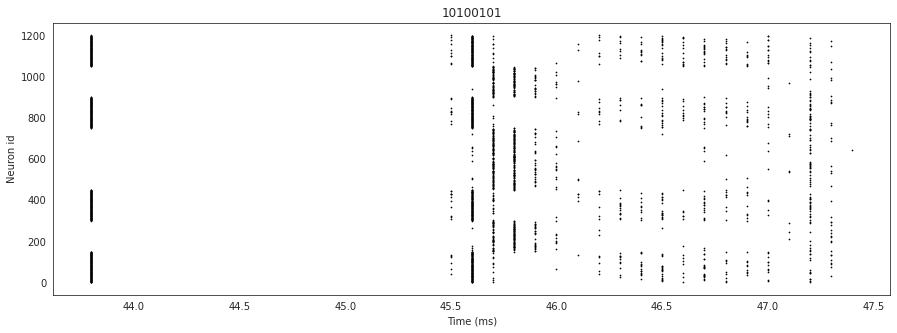

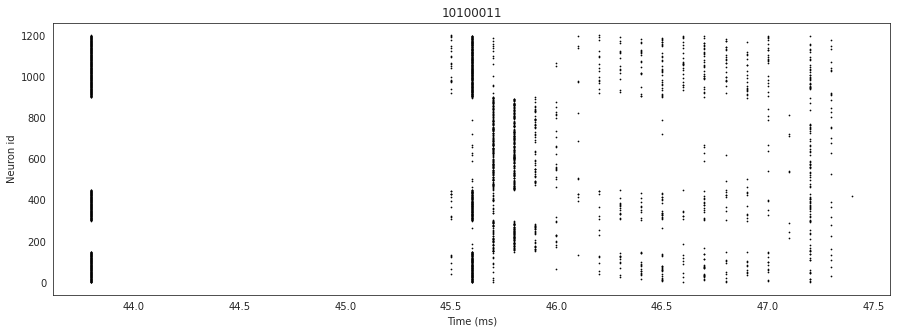

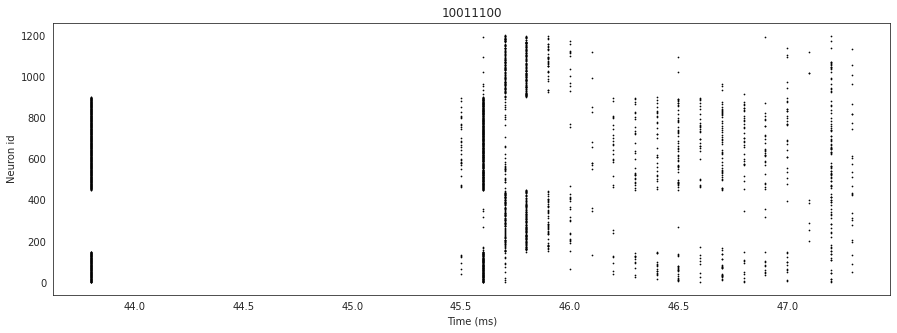

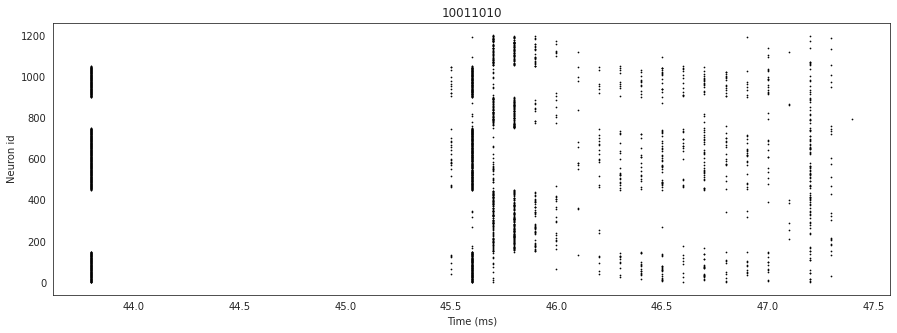

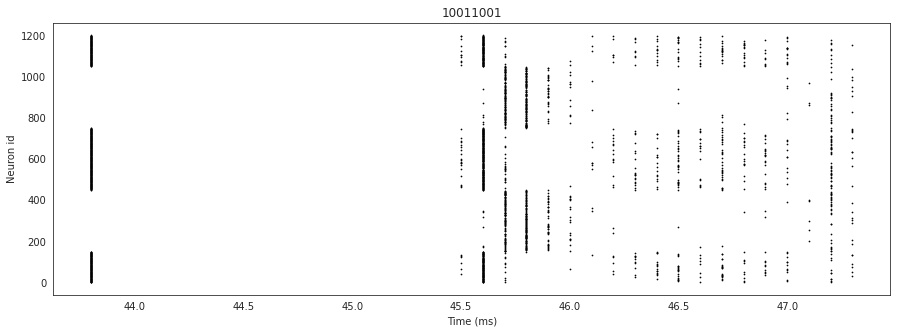

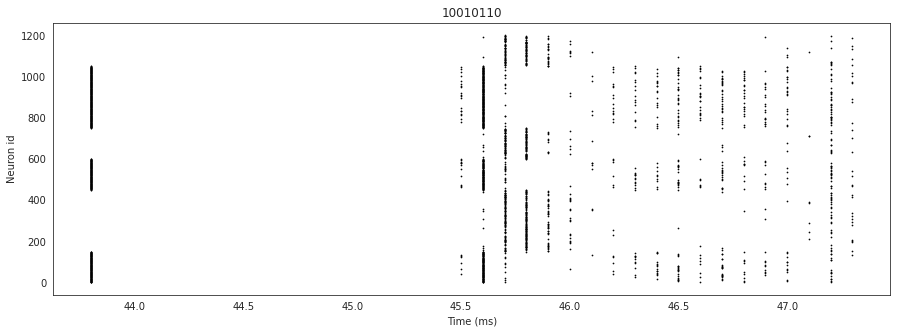

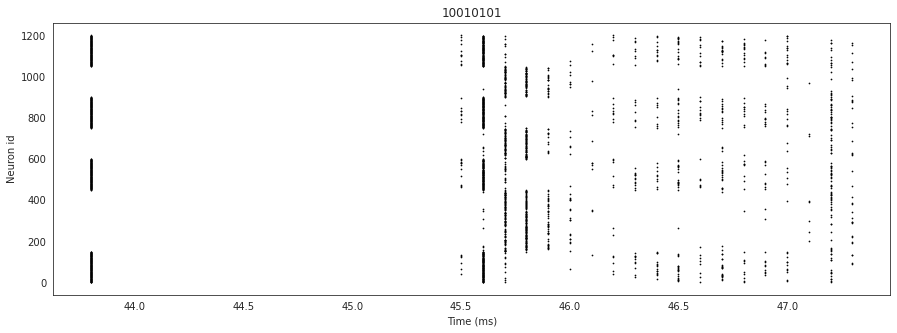

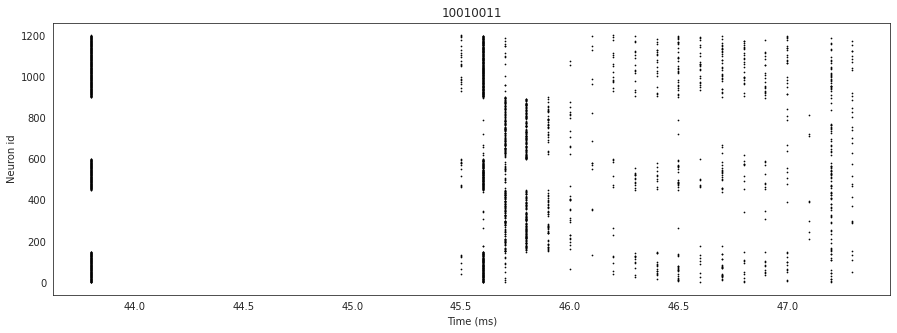

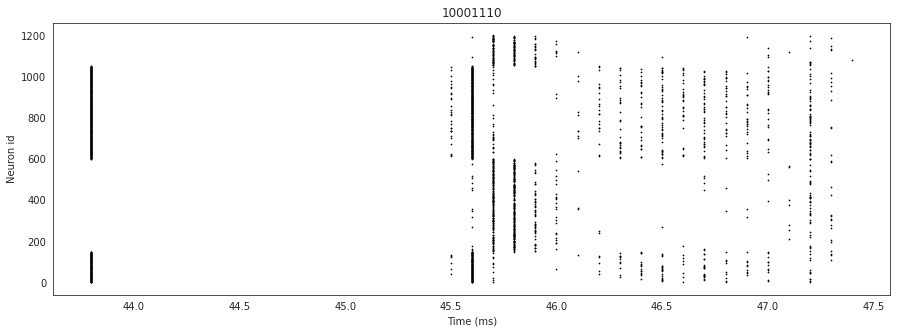

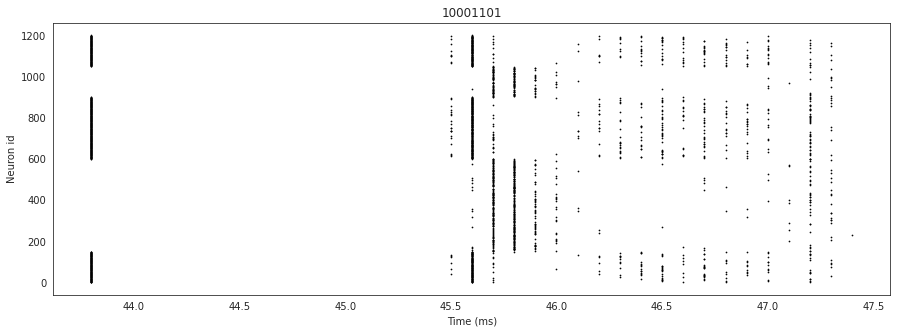

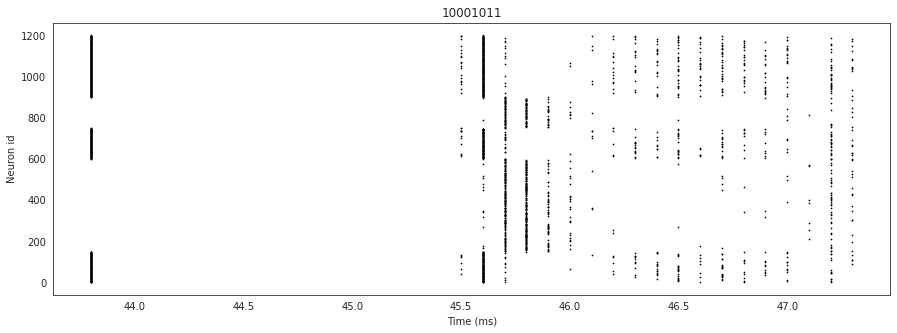

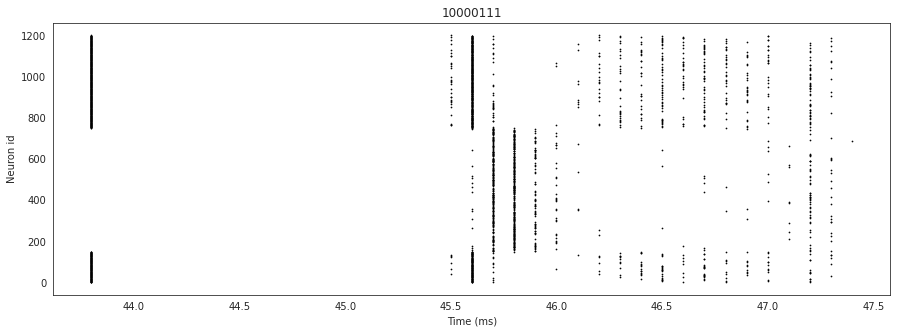

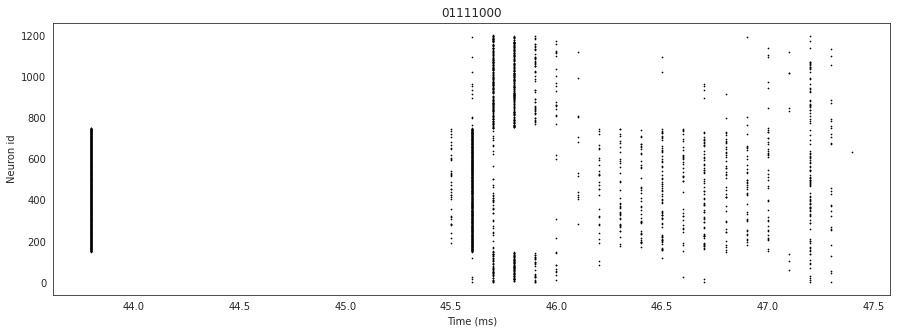

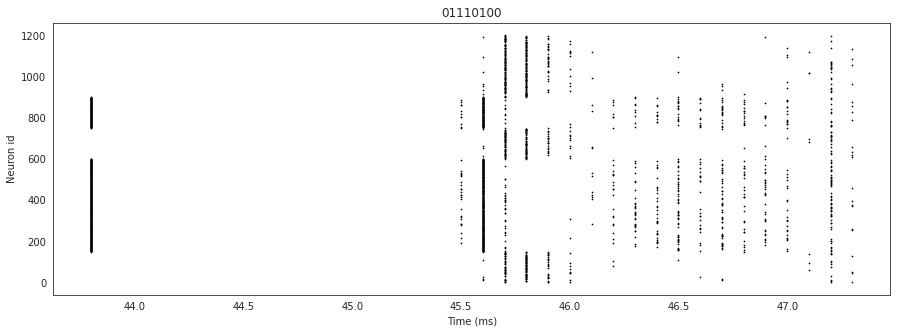

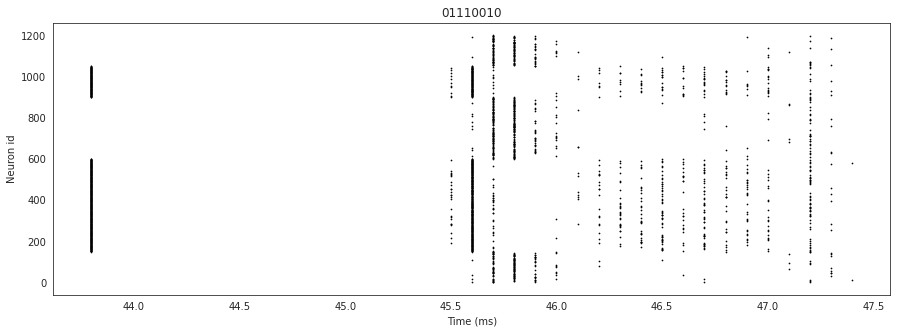

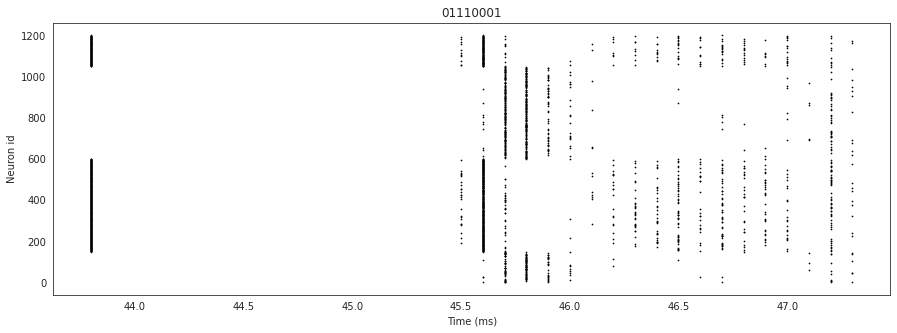

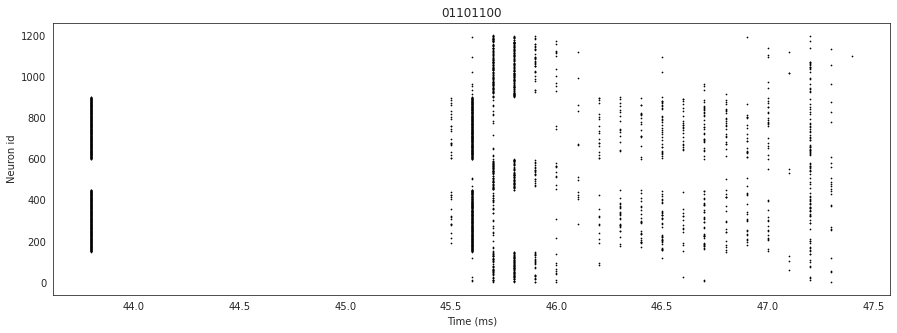

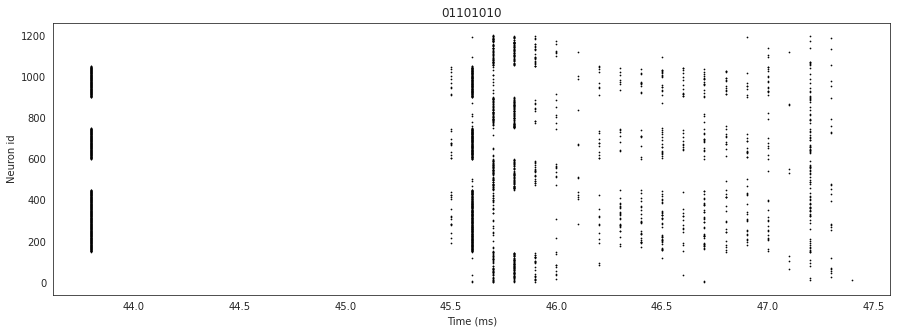

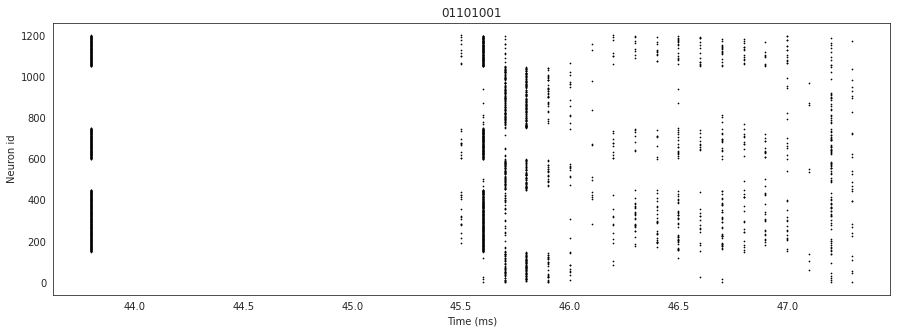

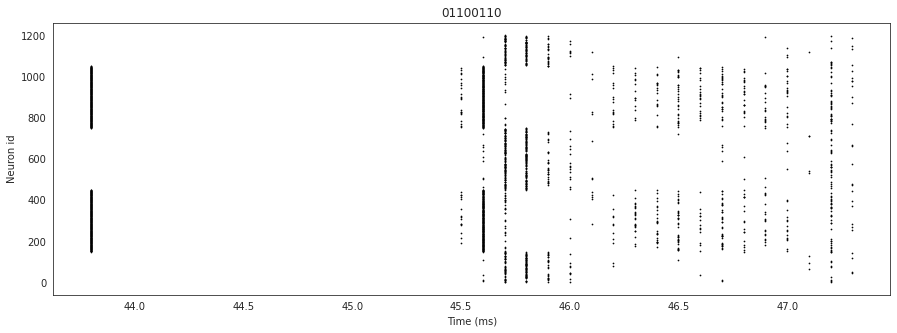

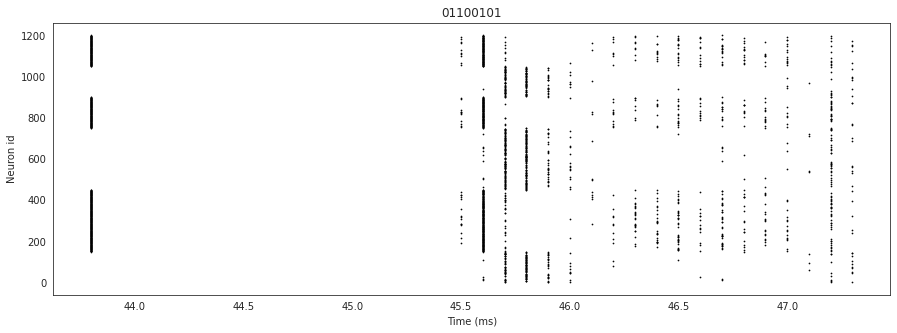

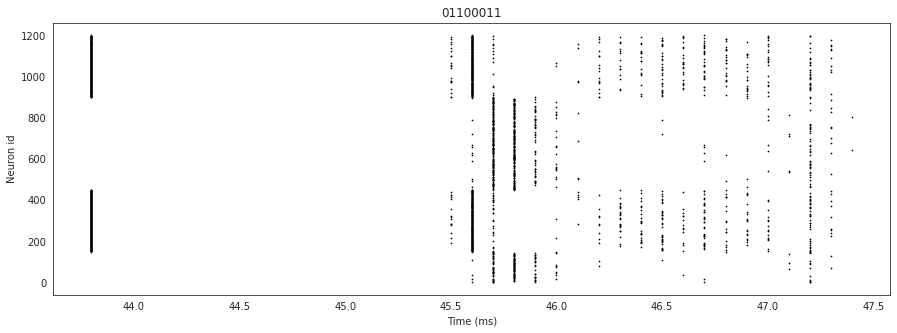

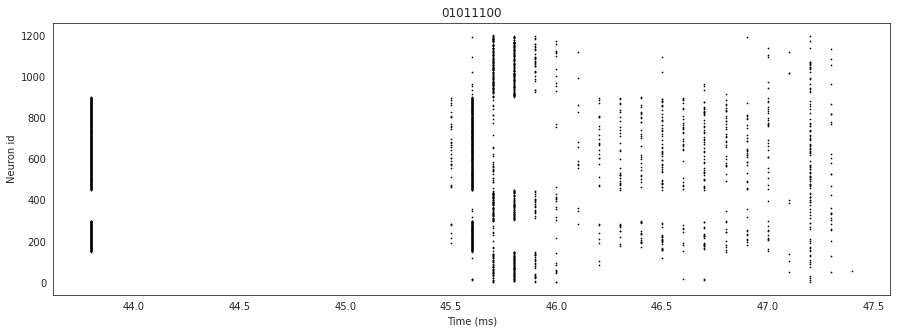

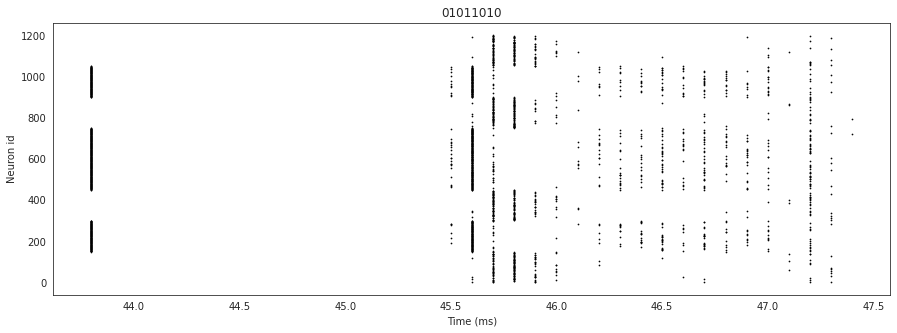

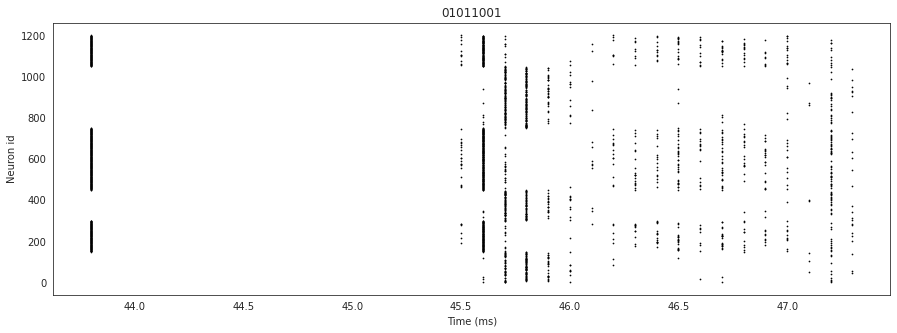

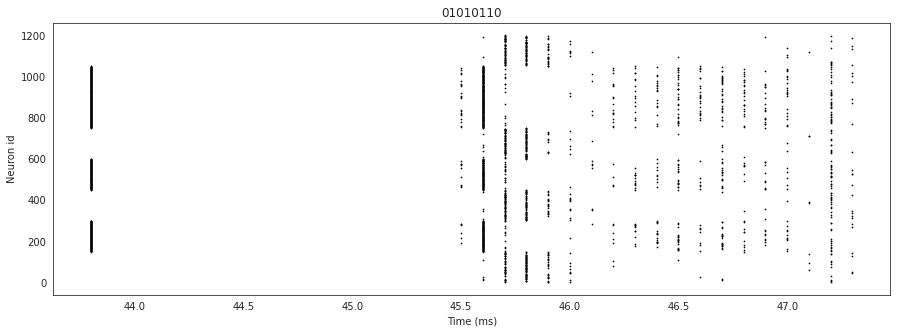

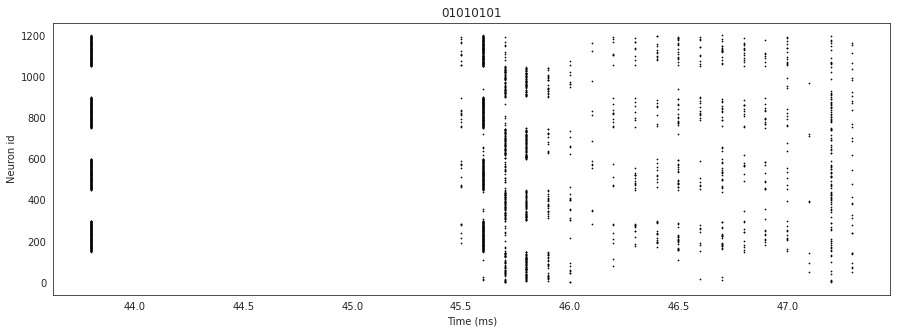

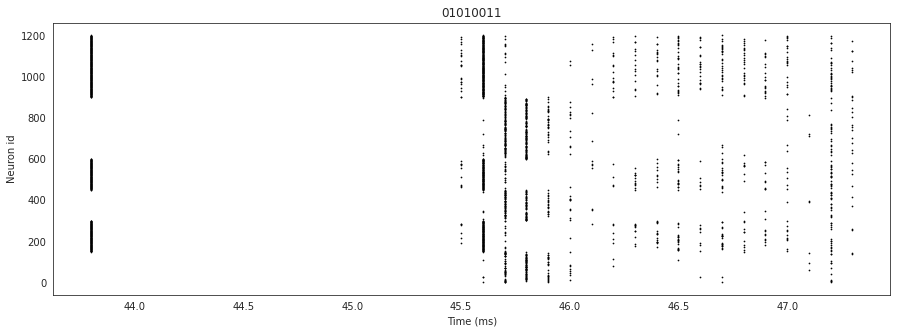

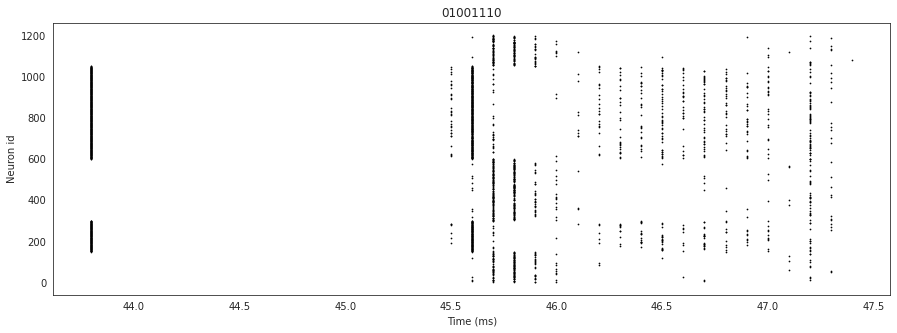

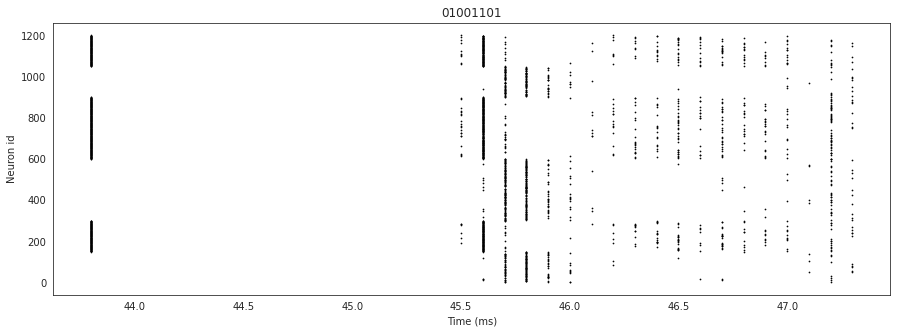

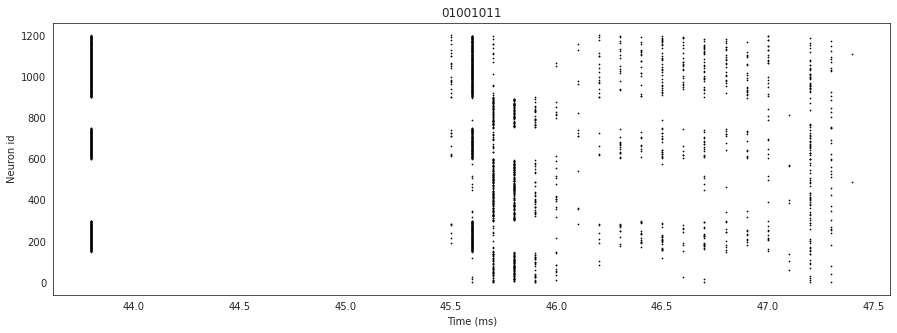

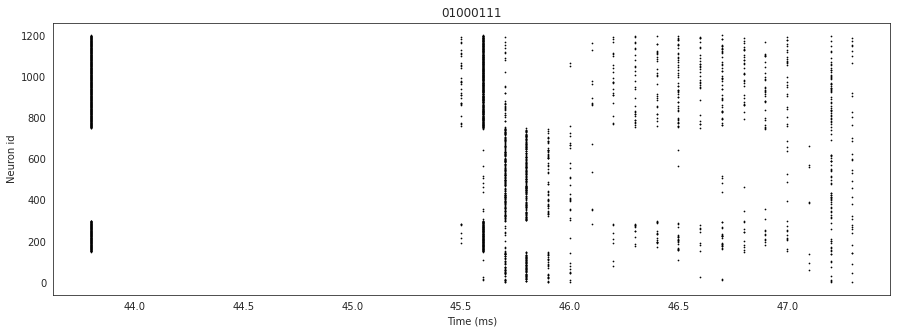

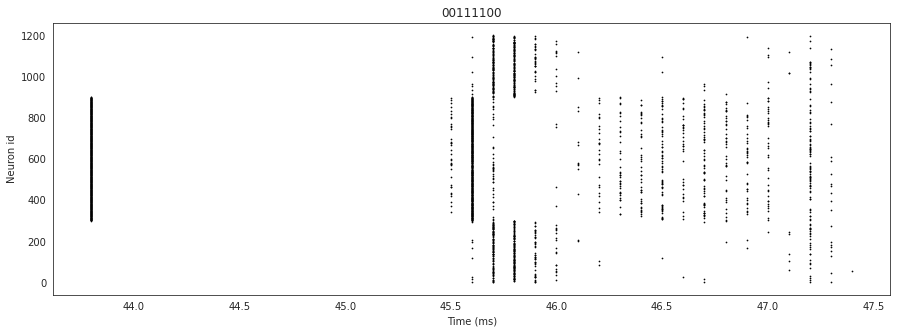

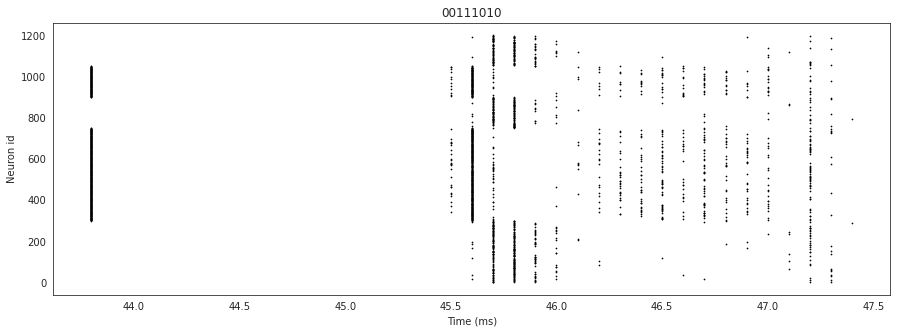

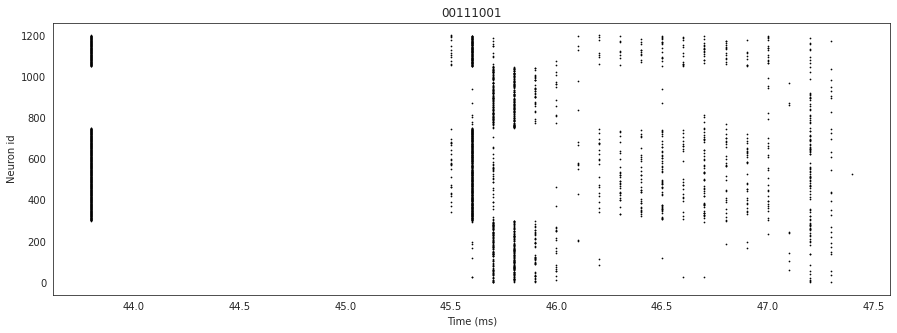

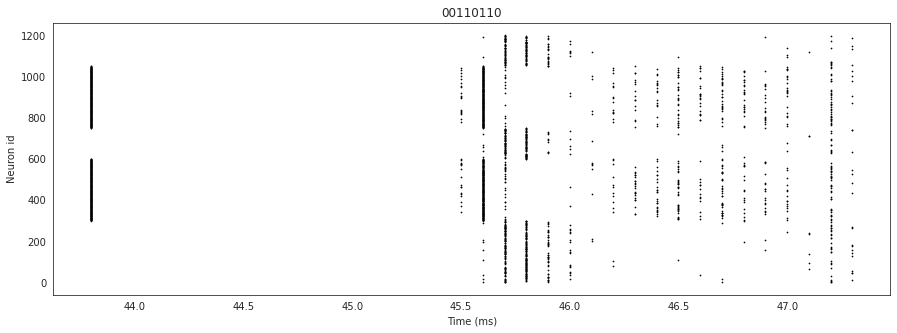

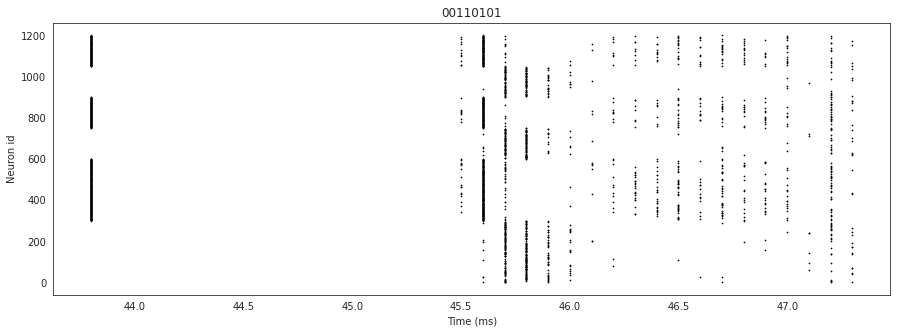

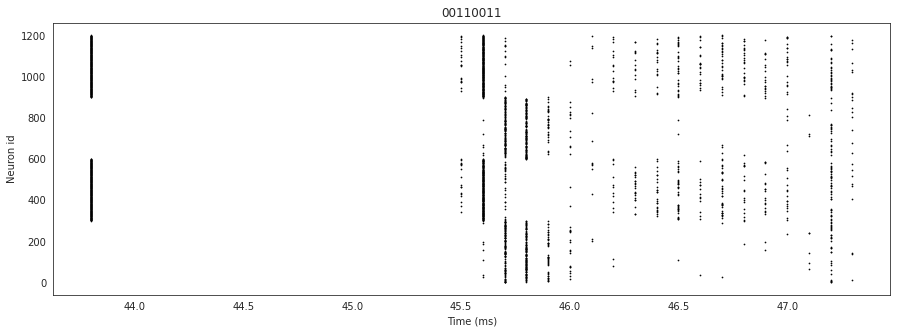

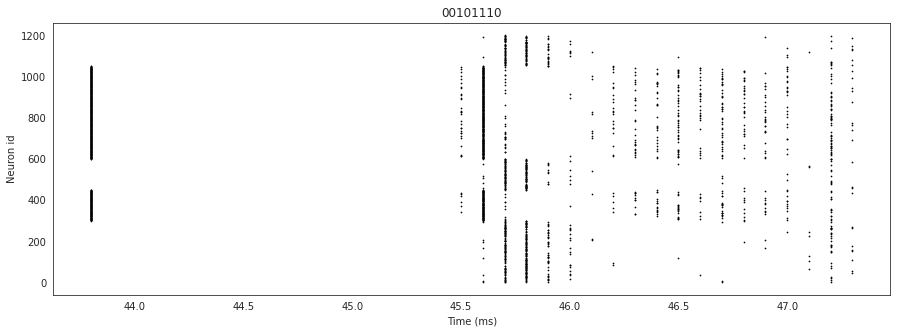

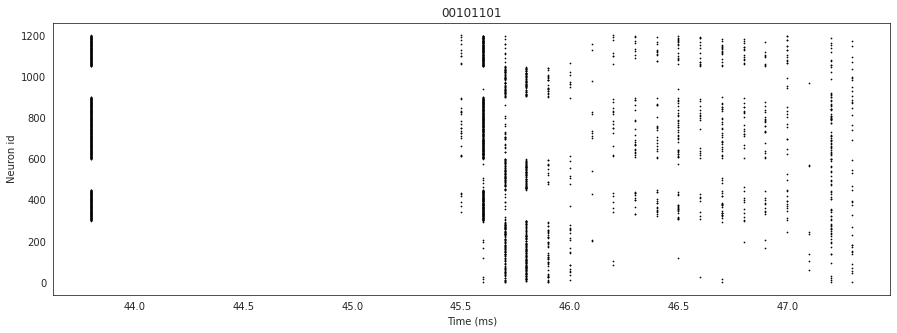

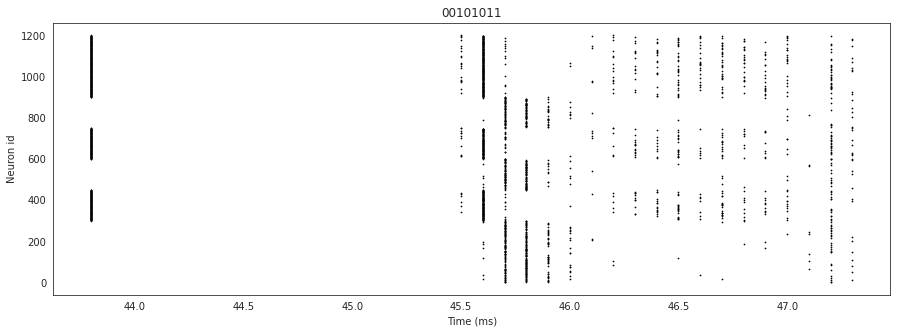

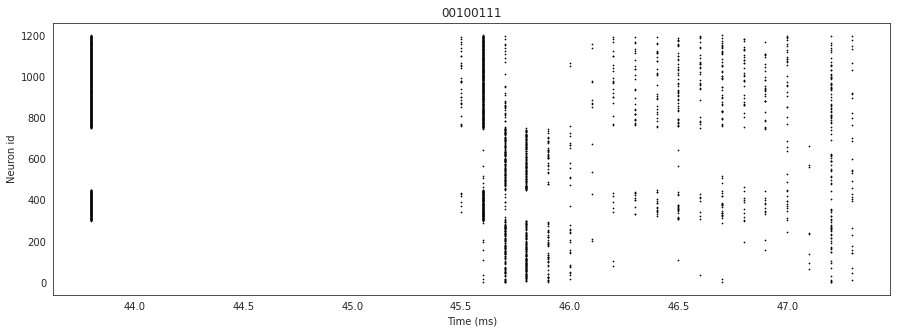

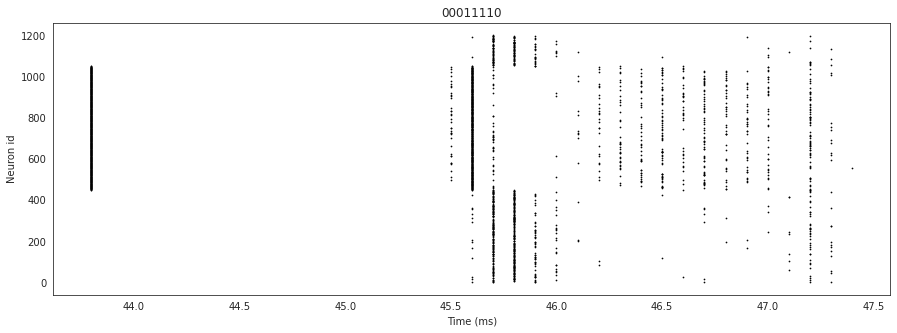

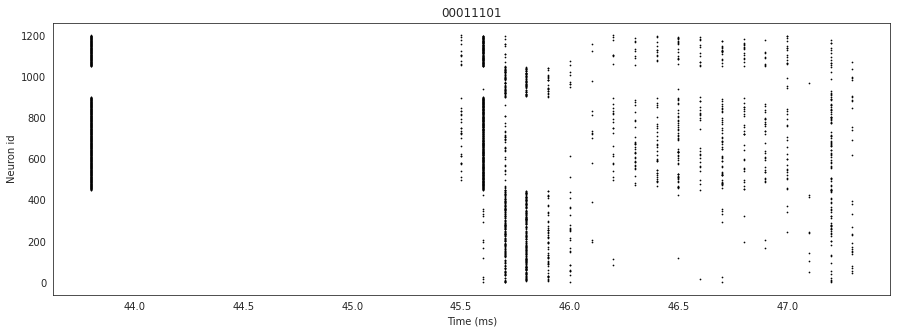

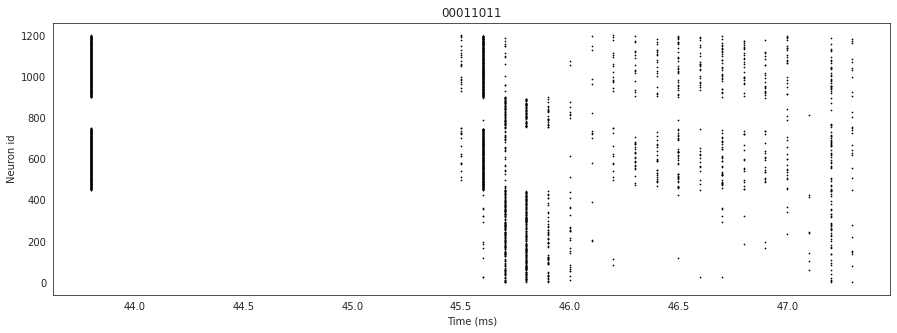

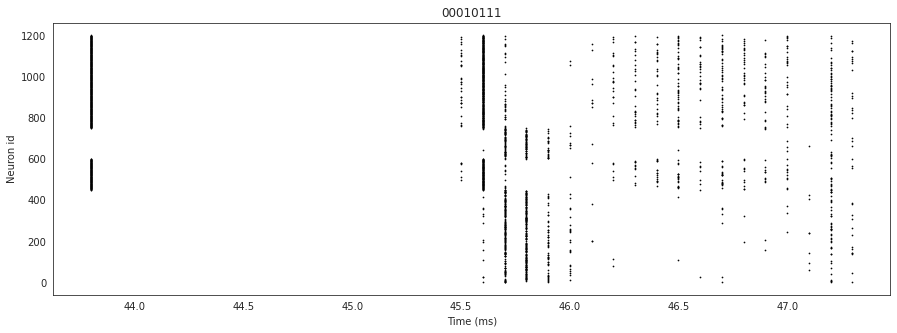

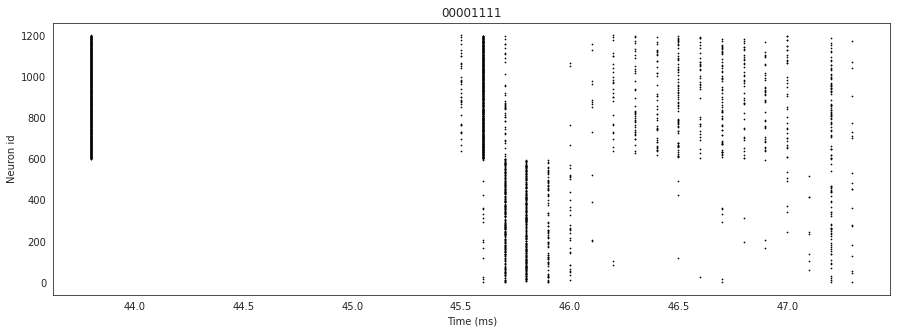

In [75]:
for i, pattern in enumerate(patterns):
    f = plt.figure(figsize=(15,5))
    plt.title(H.list2str(patterns[i]))
    plt.scatter(spike_times_arr[i], spike_neurons_arr[i], marker='o', s=0.5, color='k');
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron id');